# Depression Risk Factors Analysis: NHANES 2017-2018

## Comprehensive Machine Learning Pipeline

This notebook presents a professional, systematic analysis of depression risk factors using the National Health and Nutrition Examination Survey (NHANES) 2017-2018 dataset. The analysis follows a structured pipeline from data loading through feature importance identification and visualization.

**Note on Survey Weights**: While NHANES provides survey weights (MEC_Weight) for population-level inference, this analysis focuses on identifying risk factors and their relationships rather than estimating population prevalence. The weights are excluded from model training and visualizations to maintain focus on the underlying associations between features and depression outcomes.

**Analysis Pipeline:**
1. Data loading and validation
2. Basic dataset overview and quality checks
3. Correlation analysis and multicollinearity removal
4. Machine learning model training and comparison
5. Feature importance identification
6. Targeted visualizations for top risk factors


## 1. Environment Setup and Imports

We begin by importing essential libraries for data manipulation, statistical analysis, machine learning, and visualization.


In [58]:
# Standard library imports
import warnings
import sys
from pathlib import Path

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical analysis
import scipy.stats as stats

# Machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


project_root = str((Path.cwd().parent))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# My modules
from src.loader import load_raw_data
from src.preprocessing import run_full_preprocessing
import src.config as config

%reload_ext autoreload
%autoreload 2

# path to plots


plots_dir = Path.cwd().parent / "plots"
plots_dir.mkdir(exist_ok=True)

# Configure display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Visualization settings
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["xtick.labelsize"] = 9
plt.rcParams["ytick.labelsize"] = 9

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

print("✓ Environment configured successfully")
print(f"✓ Data directory: {config.DATA_DIR}")


✓ Environment configured successfully
✓ Data directory: C:\Users\Nikita\dev\the\data\raw


## 2. Data Loading and Validation

We utilize the custom data loading pipeline to integrate multiple NHANES data files and apply comprehensive preprocessing.


In [59]:
# Load raw data from all NHANES files
print("=" * 80)
print("STEP 1: Loading Raw NHANES Data")
print("=" * 80)

df_raw = load_raw_data()

print("\n✓ Raw data loaded successfully")
print(f"  Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"  Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Apply full preprocessing pipeline
print("\n" + "=" * 80)
print("STEP 2: Applying Preprocessing Pipeline")
print("=" * 80)

df_processed = run_full_preprocessing(df_raw)

print("\n✓ Preprocessing completed successfully")
print(
    f"  Final shape: {df_processed.shape[0]:,} rows × {df_processed.shape[1]} columns"
)
print(f"  Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Basic validation checks
print("\n" + "=" * 80)
print("DATA VALIDATION CHECKS")
print("=" * 80)

# Check for target variables
assert "PHQ9_Score" in df_processed.columns, "PHQ9_Score not found in processed data"
assert "Depression" in df_processed.columns, "Depression not found in processed data"

# Check for missing values in targets
missing_targets = df_processed[["PHQ9_Score", "Depression"]].isnull().sum()
print(f"\nMissing values in target variables:")
print(f"  PHQ9_Score: {missing_targets['PHQ9_Score']}")
print(f"  Depression: {missing_targets['Depression']}")

# Check data types
print(f"\nData types:")
print(df_processed.dtypes.value_counts())

print("\n✓ Data loading and validation complete")


STEP 1: Loading Raw NHANES Data
--- STARTING DATA INGESTION from C:\Users\Nikita\dev\the\data\raw ---
[OK] Loaded Backbone: DEMO_J (DEMO_J.XPT)
   -> Merged DPQ_J: +9 features. New Shape: (9254, 19)
   -> Merged HSQ_J: +1 features. New Shape: (9254, 20)
   -> Merged SMQ_J: +1 features. New Shape: (9254, 21)
   -> Merged ALQ_J: +1 features. New Shape: (9254, 22)
   -> Merged PAQ_J: +1 features. New Shape: (9254, 23)
   -> Merged SLQ_J: +1 features. New Shape: (9254, 24)
   -> Merged BMX_J: +2 features. New Shape: (9254, 26)
   -> Merged BPX_J: +2 features. New Shape: (9254, 28)
   -> Merged BIOPRO_J: +7 features. New Shape: (9254, 35)
   -> Merged CBC_J: +2 features. New Shape: (9254, 37)
   -> Merged HSCRP_J: +1 features. New Shape: (9254, 38)
   -> Merged PBCD_J: +3 features. New Shape: (9254, 41)
   -> Merged ALB_CR_J: +1 features. New Shape: (9254, 42)
   -> Merged VID_J: +1 features. New Shape: (9254, 43)
   -> Merged DXX_J: +3 features. New Shape: (9254, 46)
--- DATA LOADING COMPL

## 3. Basic Dataset Overview

We examine the structure and basic characteristics of the processed dataset, including target variable distribution.


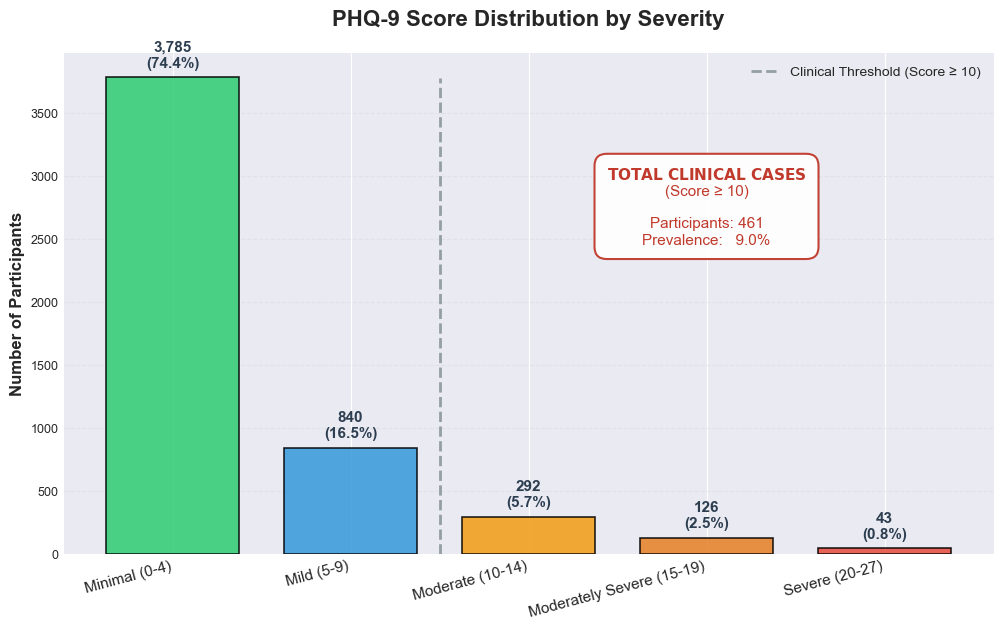

In [60]:
def plot_phq9_final_no_arrow(df):
    # Set font settings (optional, ensures clean rendering)

    # Initialize figure
    fig, ax = plt.subplots(figsize=(12, 6.5))

    # 1. Define PHQ-9 Severity Categories
    # Bins correspond to standard PHQ-9 cutoffs: 0-4, 5-9, 10-14, 15-19, 20-27
    df_viz = df.copy()
    df_viz["PHQ9_Category"] = pd.cut(
        df["PHQ9_Score"],
        bins=[-1, 4, 9, 14, 19, 27],
        labels=[
            "Minimal (0-4)",
            "Mild (5-9)",
            "Moderate (10-14)",
            "Moderately Severe (15-19)",
            "Severe (20-27)",
        ],
    )

    # Calculate counts and percentages
    category_counts = df_viz["PHQ9_Category"].value_counts().sort_index()
    category_pct = (category_counts / len(df_viz) * 100).round(1)

    # 2. Color Palette (Using the bright "Old Palette" as requested)
    # Green -> Blue -> Yellow -> Orange -> Red
    colors_palette = ["#2ecc71", "#3498db", "#f39c12", "#e67e22", "#e74c3c"]

    # 3. Draw Bar Chart
    bars = ax.bar(
        range(len(category_counts)),
        category_counts.values,
        color=colors_palette,
        alpha=0.85,  # Slight transparency
        edgecolor="black",  # Black border for contrast
        linewidth=1.2,
        width=0.75,
        zorder=3,
    )

    # 4. Add Value Labels on top of bars
    for bar, count, pct in zip(bars, category_counts.values, category_pct.values):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + (max(category_counts.values) * 0.015),  # Dynamic offset
            f"{count:,}\n({pct:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
            color="#2c3e50",
        )

    # 5. Add Clinical Threshold Line (Vertical)
    ax.axvline(
        x=1.5,
        ymin=0,
        ymax=0.95,
        color="#7f8c8d",
        linestyle="--",
        linewidth=2,
        alpha=0.8,
        label="Clinical Threshold (Score ≥ 10)",
        zorder=2,
    )

    # 6. Calculate Clinical Totals (Sum of Moderate, Mod-Severe, Severe)
    # Indices 2, 3, and 4 correspond to the clinical categories
    clinical_sum = category_counts.iloc[2:].sum()
    clinical_pct_sum = category_pct.iloc[2:].sum()

    # Formulate the annotation text
    text_str = (
        f"$\\bf{{TOTAL\\ CLINICAL\\ CASES}}$\n"  # LaTeX for bold title
        f"(Score ≥ 10)\n\n"
        f"Participants: {clinical_sum:,}\n"
        f"Prevalence:   {clinical_pct_sum:.1f}%"
    )

    # 7. Add Annotation Box (Floating, without arrow)
    # Centered roughly over the clinical section (indices 2, 3, 4)
    ax.text(
        x=3.0,  # Horizontal position: Centered around the "Moderately Severe" bar
        y=max(category_counts.values) * 0.65,  # Vertical position
        s=text_str,
        ha="center",
        fontsize=11,
        color="#c0392b",  # Dark red text
        bbox=dict(
            boxstyle="round,pad=0.8",
            fc="white",  # White background
            ec="#c0392b",  # Red border
            alpha=0.95,
            lw=1.5,
        ),
    )

    # 8. Final Styling (Clean Look)
    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # Light gray for remaining spines
    ax.spines["left"].set_color("#cfd8dc")
    ax.spines["bottom"].set_color("#cfd8dc")

    # Horizontal grid lines behind bars
    ax.grid(axis="y", linestyle="--", alpha=0.4, color="#cfd8dc", zorder=0)

    # X-axis labels formatting
    ax.set_xticks(range(len(category_counts)))
    ax.set_xticklabels(category_counts.index, rotation=15, ha="right", fontsize=11)

    # Titles and Labels
    ax.set_ylabel("Number of Participants", fontsize=12, fontweight="bold")
    ax.set_title(
        "PHQ-9 Score Distribution by Severity", fontsize=16, fontweight="bold", pad=20
    )

    # Legend
    ax.legend(loc="upper right", frameon=False, fontsize=10)

    # Layout adjustment and saving

    plt.savefig(plots_dir / "depression.png", dpi=300, bbox_inches="tight")
    plt.show()


# Execute the function (assuming df_processed is loaded)
plot_phq9_final_no_arrow(df_processed)

## 4. Correlation Analysis and Multicollinearity Removal

We construct a correlation matrix to identify highly correlated variables that may represent redundant information. Variables with strong correlations (>0.7) or those that are transformations of the same underlying measure are removed to improve model interpretability and reduce multicollinearity.

**Columns to be removed:**
- **BMI_Category**: Categorical version of BMI (information loss)
- **Lead_ugdL, Cadmium_ugL, Mercury_Total_ugL**: Original heavy metal concentrations (log-transformed versions preferred)
- **CRP_mgL**: Original C-reactive protein (log-transformed version preferred)
- **Trunk_Fat_g**: Absolute trunk fat (Body_Fat_Pct is more standardized)


Removed 6 columns to avoid multicollinearity:
  - BMI_Category
  - Lead_ugdL
  - Cadmium_ugL
  - Mercury_Total_ugL
  - CRP_mgL
  - Trunk_Fat_g

Final feature count: 32

CORRELATION MATRIX ANALYSIS


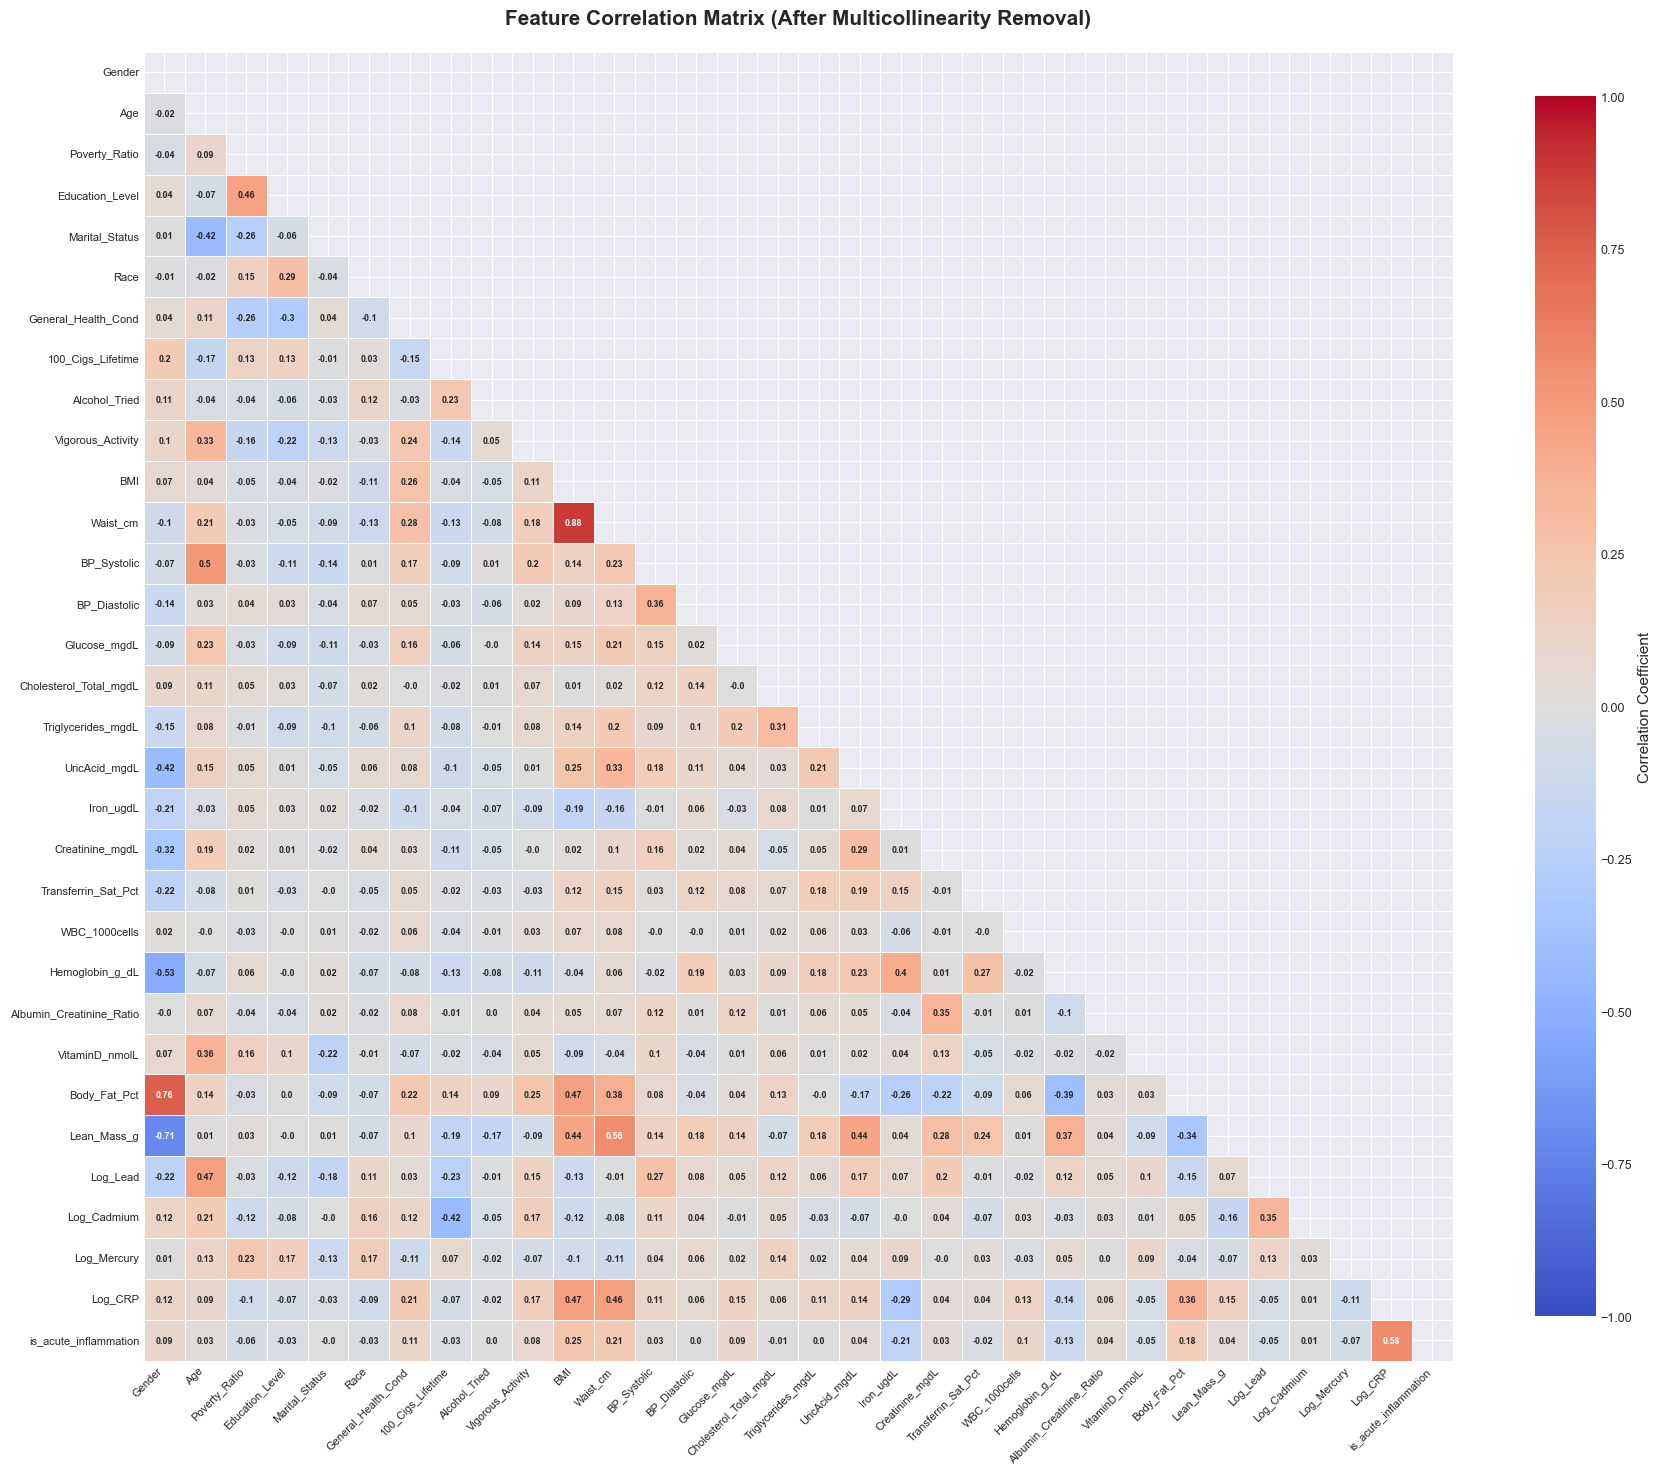


Correlation Statistics:
  Mean absolute correlation: 0.105
  Max correlation: 0.882
  Min correlation: -0.714
  Pairs with |correlation| > 0.7: 3
  Pairs with |correlation| > 0.9: 0

✓ Correlation analysis complete


In [61]:
# Extract feature matrix (exclude targets, IDs, and survey design variables)
exclude_cols = [
    "SEQN",
    "Depression",
    "PSU",
    "Strata",
    "MEC_Weight",
    "Trouble_Sleeping_Doc",
    "PHQ9_Score",  # Target variable
]

# Get all feature columns
X = df_processed[
    [col for col in df_processed.columns if col not in exclude_cols]
].copy()

# Remove columns to eliminate multicollinearity and duplicates
cols_to_remove = [
    "BMI_Category",
    "Lead_ugdL",
    "Cadmium_ugL",
    "Mercury_Total_ugL",
    "CRP_mgL",
    "Trunk_Fat_g",
]

# Remove columns if they exist
existing_cols_to_remove = [col for col in cols_to_remove if col in X.columns]
if existing_cols_to_remove:
    X = X.drop(columns=existing_cols_to_remove)
    df_processed = df_processed.drop(columns=existing_cols_to_remove)
    print(f"Removed {len(existing_cols_to_remove)} columns to avoid multicollinearity:")
    for col in existing_cols_to_remove:
        print(f"  - {col}")

print(f"\nFinal feature count: {X.shape[1]}")

# Calculate correlation matrix
print("\n" + "=" * 80)
print("CORRELATION MATRIX ANALYSIS")
print("=" * 80)

corr_matrix = X.corr()

# Create visualization
fig, ax = plt.subplots(figsize=(18, 16))

# Create mask for upper triangle (including diagonal)
mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)

# Create annotation matrix (only show in lower triangle)
annot_matrix = corr_matrix.copy()
annot_array = np.round(annot_matrix.values, 2).astype(str)
annot_array[mask_upper] = ""
annot_matrix = pd.DataFrame(
    annot_array, index=corr_matrix.index, columns=corr_matrix.columns
)

# Create heatmap
sns.heatmap(
    corr_matrix,
    mask=mask_upper,
    annot=annot_matrix,
    annot_kws={"size": 6.5, "weight": "bold"},
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
    fmt="",
    vmin=-1,
    vmax=1,
    ax=ax,
)

ax.set_title(
    "Feature Correlation Matrix (After Multicollinearity Removal)",
    fontsize=15,
    fontweight="bold",
    pad=20,
)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(plots_dir / "correlation_Matrix", dpi=300, bbox_inches="tight")
plt.show()

# Summary statistics of correlations
mask_upper_stats = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_values = corr_matrix.values[mask_upper_stats]

print(f"\nCorrelation Statistics:")
print(f"  Mean absolute correlation: {np.abs(corr_values).mean():.3f}")
print(f"  Max correlation: {corr_values.max():.3f}")
print(f"  Min correlation: {corr_values.min():.3f}")
print(f"  Pairs with |correlation| > 0.7: {np.sum(np.abs(corr_values) > 0.7)}")
print(f"  Pairs with |correlation| > 0.9: {np.sum(np.abs(corr_values) > 0.9)}")

print("\n✓ Correlation analysis complete")


In [62]:
# ==============================================================================
# DATA PREPARATION FOR ML
# ==============================================================================
print("=" * 80)
print("MACHINE LEARNING MODEL TRAINING")
print("=" * 80)

# Use the same feature exclusion as correlation analysis
exclude_cols_ml = [
    "SEQN",
    "Depression",
    "PSU",
    "Strata",
    "MEC_Weight",
    "Trouble_Sleeping_Doc",
    "PHQ9_Score",
]

# Get feature columns
X_ml = df_processed[
    [col for col in df_processed.columns if col not in exclude_cols_ml]
].copy()

# Remove columns to avoid multicollinearity (same as correlation analysis)
cols_to_remove_ml = [
    "BMI_Category",
    "Lead_ugdL",
    "Cadmium_ugL",
    "Mercury_Total_ugL",
    "CRP_mgL",
    "Trunk_Fat_g",
]

existing_cols_to_remove_ml = [col for col in cols_to_remove_ml if col in X_ml.columns]
if existing_cols_to_remove_ml:
    X_ml = X_ml.drop(columns=existing_cols_to_remove_ml)

# Get target variable (binary classification)
y_ml = df_processed["Depression"].copy()

# Remove rows with missing values
mask_ml = ~(y_ml.isna() | X_ml.isna().any(axis=1))
X_ml_clean = X_ml[mask_ml].copy()
y_ml_clean = y_ml[mask_ml].copy()

print(f"\nDataset Statistics:")
print(f"  Total samples: {len(X_ml_clean):,}")
print(f"  Number of features: {X_ml_clean.shape[1]}")
print(f"  Depression cases (1): {y_ml_clean.sum():,} ({y_ml_clean.mean() * 100:.2f}%)")
print(
    f"  No depression cases (0): {(y_ml_clean == 0).sum():,} ({(1 - y_ml_clean.mean()) * 100:.2f}%)"
)
print(f"  Class imbalance ratio: {(y_ml_clean == 0).sum() / y_ml_clean.sum():.2f}:1")

# Split data into train and test sets (stratified)
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml_clean, y_ml_clean, test_size=0.2, random_state=42, stratify=y_ml_clean
)

print(f"\nTrain set: {X_train_ml.shape[0]:,} samples")
print(f"Test set: {X_test_ml.shape[0]:,} samples")
print(f"Train set depression rate: {y_train_ml.mean() * 100:.2f}%")
print(f"Test set depression rate: {y_test_ml.mean() * 100:.2f}%")

# ==============================================================================
# HANDLE CLASS IMBALANCE WITH SMOTE
# ==============================================================================
print("\n" + "=" * 80)
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("=" * 80)

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_ml, y_train_ml)

print(f"Before SMOTE:")
print(f"  Train samples: {len(X_train_ml):,}")
print(f"  Depression cases: {y_train_ml.sum():,} ({y_train_ml.mean() * 100:.2f}%)")
print(
    f"  No depression cases: {(y_train_ml == 0).sum():,} ({(1 - y_train_ml.mean()) * 100:.2f}%)"
)

print(f"\nAfter SMOTE:")
print(f"  Train samples: {len(X_train_balanced):,}")
print(
    f"  Depression cases: {y_train_balanced.sum():,} ({y_train_balanced.mean() * 100:.2f}%)"
)
print(
    f"  No depression cases: {(y_train_balanced == 0).sum():,} ({(1 - y_train_balanced.mean()) * 100:.2f}%)"
)


MACHINE LEARNING MODEL TRAINING

Dataset Statistics:
  Total samples: 5,086
  Number of features: 32
  Depression cases (1): 461.0 (9.06%)
  No depression cases (0): 4,625 (90.94%)
  Class imbalance ratio: 10.03:1

Train set: 4,068 samples
Test set: 1,018 samples
Train set depression rate: 9.07%
Test set depression rate: 9.04%

HANDLING CLASS IMBALANCE WITH SMOTE
Before SMOTE:
  Train samples: 4,068
  Depression cases: 369.0 (9.07%)
  No depression cases: 3,699 (90.93%)

After SMOTE:
  Train samples: 7,398
  Depression cases: 3,699.0 (50.00%)
  No depression cases: 3,699 (50.00%)


In [63]:
# ==============================================================================
# TRAIN MULTIPLE MODELS
# ==============================================================================
print("\n" + "=" * 80)
print("TRAINING MULTIPLE ML MODELS")
print("=" * 80)

models = {}
results = {}

# Calculate scale_pos_weight for XGBoost and LightGBM
scale_pos_weight = (y_train_ml == 0).sum() / y_train_ml.sum()

# 3.1 XGBoost Classifier
print("\n[1/4] Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1,
)
xgb_model.fit(X_train_balanced, y_train_balanced)
models["XGBoost"] = xgb_model

# 3.2 LightGBM Classifier
print("[2/4] Training LightGBM Classifier...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=-1,
    n_jobs=-1,
)
lgb_model.fit(X_train_balanced, y_train_balanced)
models["LightGBM"] = lgb_model

# 3.3 Random Forest Classifier
print("[3/4] Training Random Forest Classifier...")
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)
rf_clf.fit(X_train_balanced, y_train_balanced)
models["Random Forest"] = rf_clf

# 3.4 Logistic Regression (with scaling)
print("[4/4] Training Logistic Regression...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_ml)

lr_model = LogisticRegression(
    max_iter=1000, class_weight="balanced", random_state=42, C=1.0
)
lr_model.fit(X_train_scaled, y_train_balanced)
models["Logistic Regression"] = lr_model
models["Scaler"] = scaler

print("\n✓ All models trained successfully!")



TRAINING MULTIPLE ML MODELS

[1/4] Training XGBoost Classifier...
[2/4] Training LightGBM Classifier...
[3/4] Training Random Forest Classifier...
[4/4] Training Logistic Regression...

✓ All models trained successfully!



MODEL EVALUATION

--------------------------------------------------------------------------------
Evaluating XGBoost:
--------------------------------------------------------------------------------
  Accuracy:  0.8841
  Precision: 0.3088
  Recall:    0.2283
  F1-Score:  0.2625
  ROC-AUC:   0.7594

  Confusion Matrix:
                 Predicted
                 No Dep  Dep
  Actual No Dep     879   47
         Dep         71   21

--------------------------------------------------------------------------------
Evaluating LightGBM:
--------------------------------------------------------------------------------
  Accuracy:  0.8792
  Precision: 0.3368
  Recall:    0.3478
  F1-Score:  0.3422
  ROC-AUC:   0.7330

  Confusion Matrix:
                 Predicted
                 No Dep  Dep
  Actual No Dep     863   63
         Dep         60   32

--------------------------------------------------------------------------------
Evaluating Random Forest:
-------------------------------------

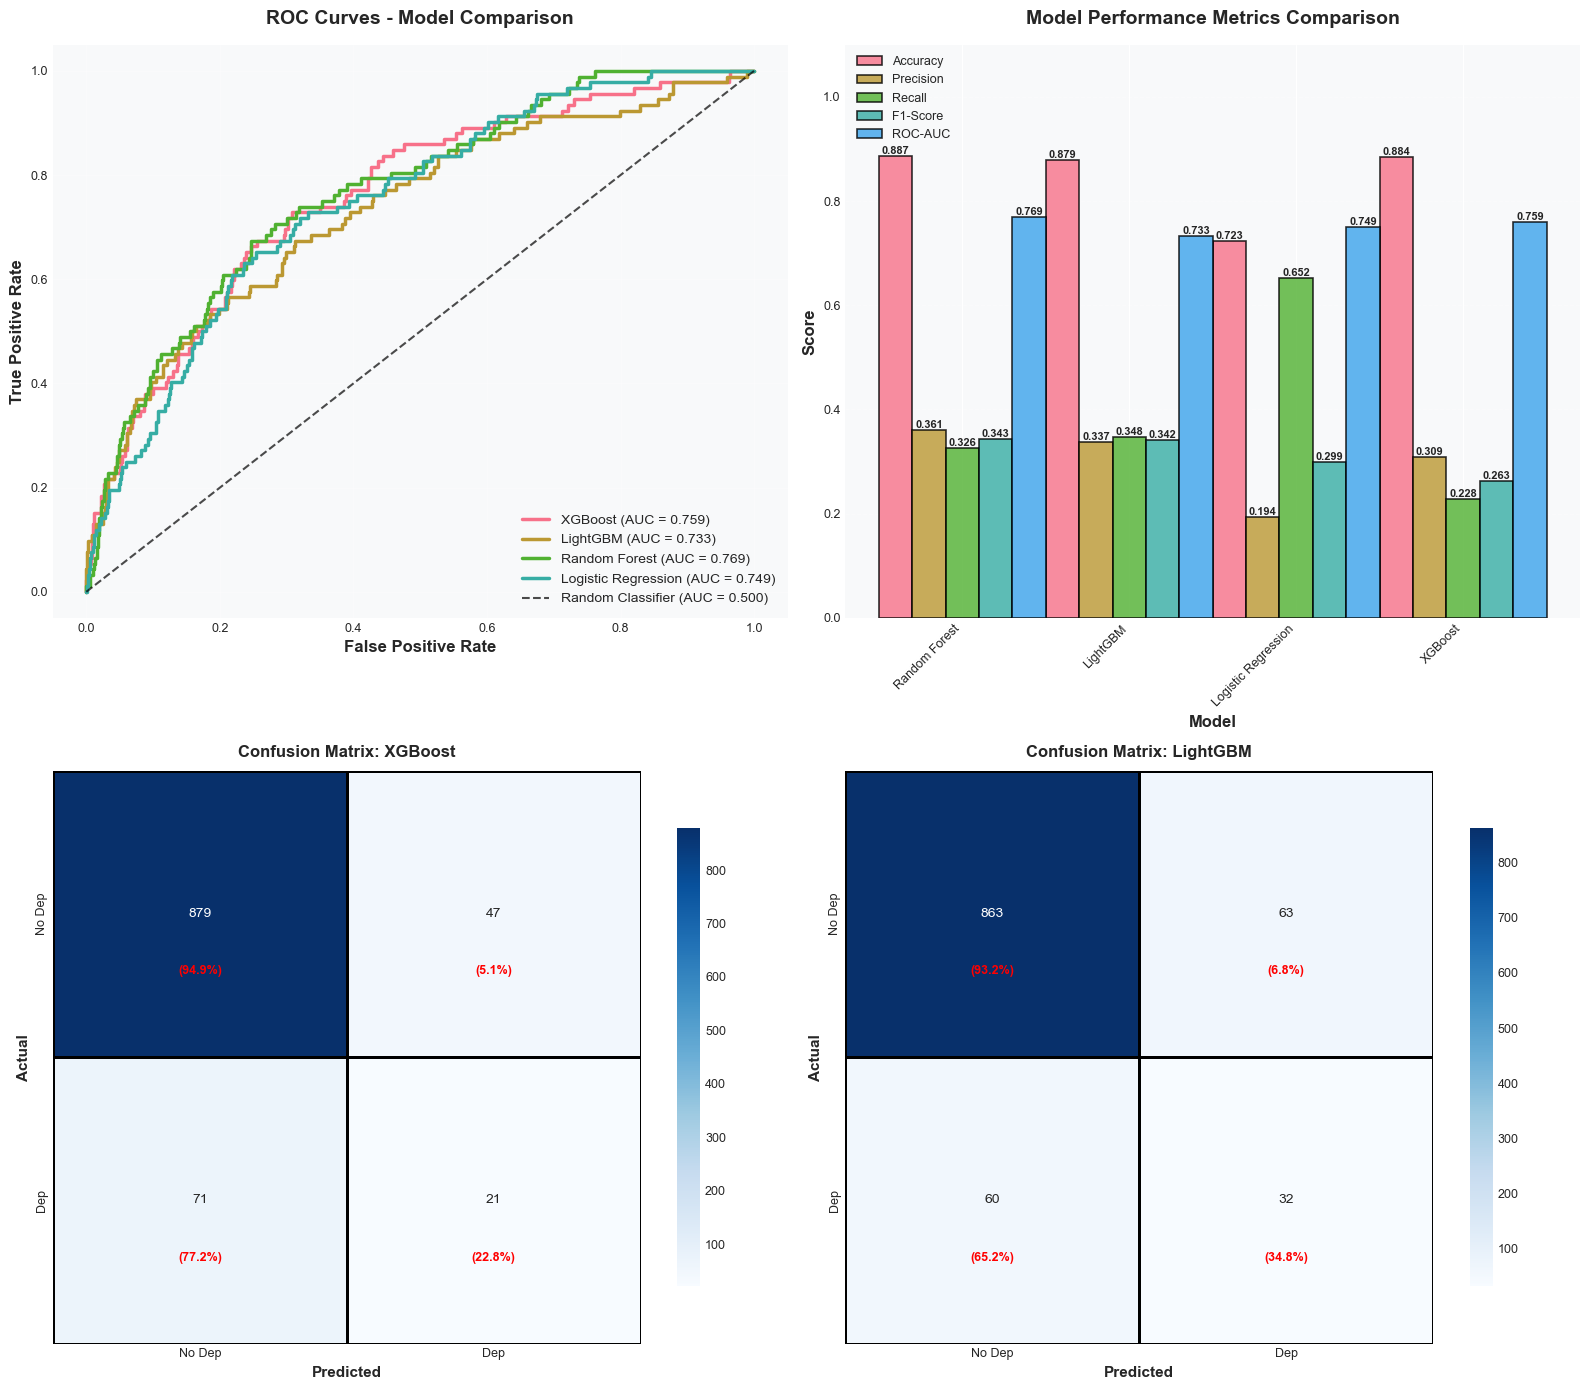

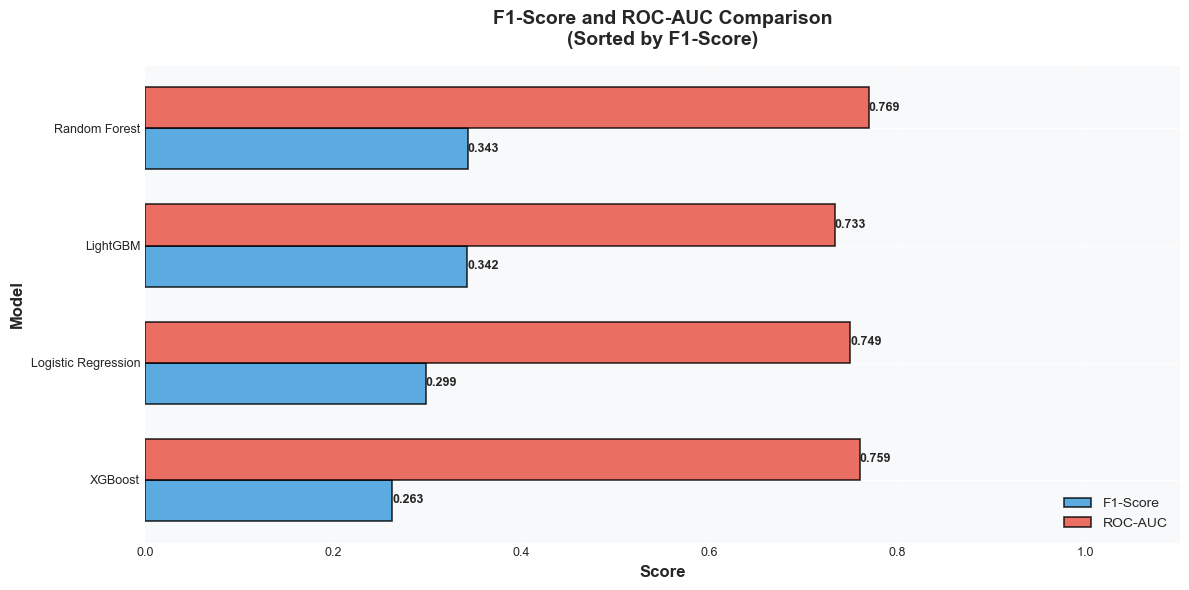

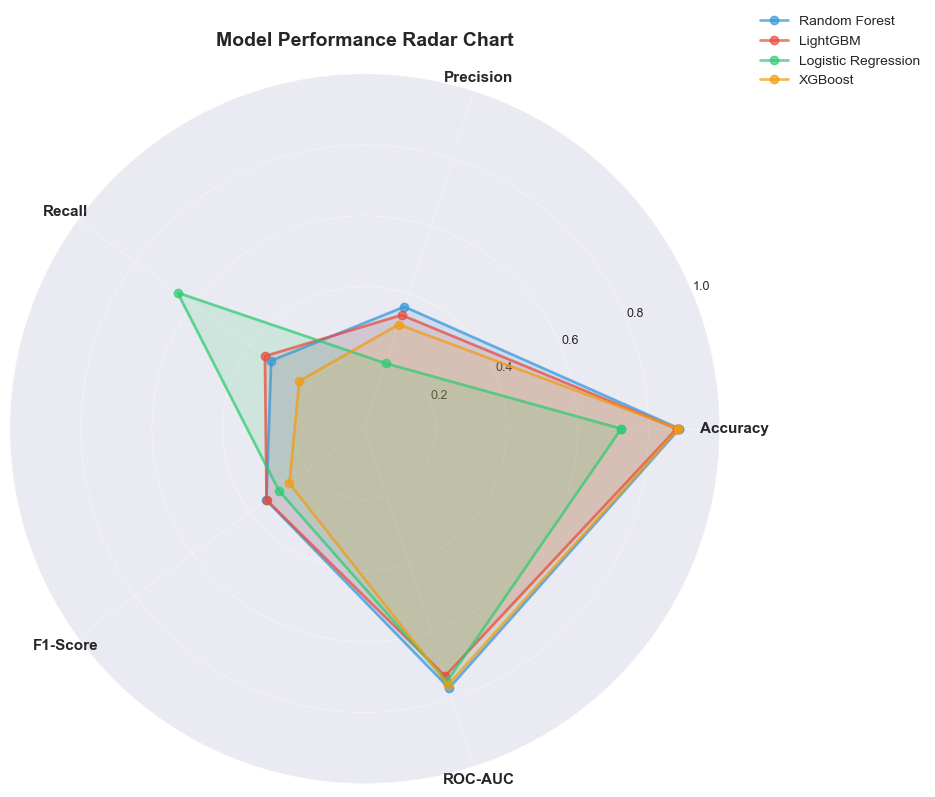


✓ Model comparison visualizations created successfully


In [64]:
# ==============================================================================
# MODEL EVALUATION
# ==============================================================================
print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

# Evaluate each model
for name, model in models.items():
    if name == "Scaler":
        continue

    print(f"\n{'-' * 80}")
    print(f"Evaluating {name}:")
    print(f"{'-' * 80}")

    # Make predictions
    if name == "Logistic Regression":
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred = model.predict(X_test_ml)
        y_pred_proba = model.predict_proba(X_test_ml)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test_ml, y_pred)
    precision = precision_score(y_test_ml, y_pred, zero_division=0)
    recall = recall_score(y_test_ml, y_pred, zero_division=0)
    f1 = f1_score(y_test_ml, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test_ml, y_pred_proba)

    # Store results
    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "predictions": y_pred,
        "probabilities": y_pred_proba,
    }

    # Print metrics
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test_ml, y_pred)
    print(f"\n  Confusion Matrix:")
    print(f"                 Predicted")
    print(f"                 No Dep  Dep")
    print(f"  Actual No Dep   {cm[0, 0]:5d}  {cm[0, 1]:3d}")
    print(f"         Dep      {cm[1, 0]:5d}  {cm[1, 1]:3d}")

# ==============================================================================
# SELECT BEST MODEL
# ==============================================================================
print("\n" + "=" * 80)
print("MODEL COMPARISON AND SELECTION")
print("=" * 80)

# Create comparison DataFrame
comparison_df = pd.DataFrame(
    {
        "Model": list(results.keys()),
        "Accuracy": [results[m]["accuracy"] for m in results.keys()],
        "Precision": [results[m]["precision"] for m in results.keys()],
        "Recall": [results[m]["recall"] for m in results.keys()],
        "F1-Score": [results[m]["f1"] for m in results.keys()],
        "ROC-AUC": [results[m]["roc_auc"] for m in results.keys()],
    }
)

# Sort by F1-Score (best metric for imbalanced classification)
comparison_df = comparison_df.sort_values("F1-Score", ascending=False)

print("\nModel Performance Comparison (sorted by F1-Score):")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Select best model (highest F1-Score)
best_model_name = comparison_df.iloc[0]["Model"]
best_model = models[best_model_name]

print(f"\n{'=' * 80}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'=' * 80}")
print(f"  F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")
print(f"  ROC-AUC:  {comparison_df.iloc[0]['ROC-AUC']:.4f}")
print(f"  Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"  Precision: {comparison_df.iloc[0]['Precision']:.4f}")
print(f"  Recall:   {comparison_df.iloc[0]['Recall']:.4f}")

# ==============================================================================
# MODEL COMPARISON VISUALIZATIONS
# ==============================================================================
print("\n" + "=" * 80)
print("MODEL COMPARISON VISUALIZATIONS")
print("=" * 80)

# 1. ROC Curves for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# ROC Curves
ax_roc = axes[0, 0]
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test_ml, result["probabilities"])
    ax_roc.plot(
        fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.3f})", linewidth=2.5
    )

# Plot diagonal line (random classifier)
ax_roc.plot(
    [0, 1],
    [0, 1],
    "k--",
    label="Random Classifier (AUC = 0.500)",
    linewidth=1.5,
    alpha=0.7,
)

ax_roc.set_xlabel("False Positive Rate", fontsize=12, fontweight="bold")
ax_roc.set_ylabel("True Positive Rate", fontsize=12, fontweight="bold")
ax_roc.set_title(
    "ROC Curves - Model Comparison", fontsize=14, fontweight="bold", pad=15
)
ax_roc.legend(loc="lower right", fontsize=10)
ax_roc.grid(True, alpha=0.3)
ax_roc.set_facecolor("#f8f9fa")

# 2. Metrics Comparison Bar Chart
ax_metrics = axes[0, 1]
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
x_pos = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    offset = (i - 2) * width
    bars = ax_metrics.bar(
        x_pos + offset,
        comparison_df[metric],
        width,
        label=metric,
        alpha=0.8,
        edgecolor="black",
        linewidth=1.2,
    )

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax_metrics.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

ax_metrics.set_xlabel("Model", fontsize=12, fontweight="bold")
ax_metrics.set_ylabel("Score", fontsize=12, fontweight="bold")
ax_metrics.set_title(
    "Model Performance Metrics Comparison", fontsize=14, fontweight="bold", pad=15
)
ax_metrics.set_xticks(x_pos)
ax_metrics.set_xticklabels(comparison_df["Model"], rotation=45, ha="right")
ax_metrics.legend(loc="upper left", fontsize=9)
ax_metrics.set_ylim([0, 1.1])
ax_metrics.grid(True, alpha=0.3, axis="y", linestyle="--")
ax_metrics.set_facecolor("#f8f9fa")

# 3. Confusion Matrices for all models
confusion_axes = [axes[1, 0], axes[1, 1]]
model_names_list = list(results.keys())
for idx, (name, result) in enumerate(results.items()):
    if idx >= 2:  # Only show first 2 models in confusion matrices
        break
    ax_cm = confusion_axes[idx]
    cm = confusion_matrix(y_test_ml, result["predictions"])

    # Create heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax_cm,
        cbar_kws={"shrink": 0.8},
        linewidths=1,
        linecolor="black",
        xticklabels=["No Dep", "Dep"],
        yticklabels=["No Dep", "Dep"],
    )

    ax_cm.set_xlabel("Predicted", fontsize=11, fontweight="bold")
    ax_cm.set_ylabel("Actual", fontsize=11, fontweight="bold")
    ax_cm.set_title(f"Confusion Matrix: {name}", fontsize=12, fontweight="bold", pad=10)

    # Calculate percentages
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    for i in range(2):
        for j in range(2):
            ax_cm.text(
                j + 0.5,
                i + 0.7,
                f"({cm_percent[i, j]:.1f}%)",
                ha="center",
                va="center",
                fontsize=9,
                color="red",
                fontweight="bold",
            )

plt.tight_layout()
plt.savefig(plots_dir / "model_Comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# 4. F1-Score and ROC-AUC Comparison (Horizontal Bar Chart)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Sort by F1-Score for better visualization
comparison_sorted = comparison_df.sort_values("F1-Score", ascending=True)

y_pos = np.arange(len(comparison_sorted))
width_bar = 0.35

bars1 = ax.barh(
    y_pos - width_bar / 2,
    comparison_sorted["F1-Score"],
    width_bar,
    label="F1-Score",
    color="#3498db",
    alpha=0.8,
    edgecolor="black",
    linewidth=1.2,
)
bars2 = ax.barh(
    y_pos + width_bar / 2,
    comparison_sorted["ROC-AUC"],
    width_bar,
    label="ROC-AUC",
    color="#e74c3c",
    alpha=0.8,
    edgecolor="black",
    linewidth=1.2,
)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        width = bar.get_width()
        ax.text(
            width,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.3f}",
            ha="left",
            va="center",
            fontsize=9,
            fontweight="bold",
        )

ax.set_yticks(y_pos)
ax.set_yticklabels(comparison_sorted["Model"])
ax.set_xlabel("Score", fontsize=12, fontweight="bold")
ax.set_ylabel("Model", fontsize=12, fontweight="bold")
ax.set_title(
    "F1-Score and ROC-AUC Comparison\n(Sorted by F1-Score)",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax.legend(loc="lower right", fontsize=10)
ax.set_xlim([0, 1.1])
ax.grid(True, alpha=0.3, axis="x", linestyle="--")
ax.set_facecolor("#f8f9fa")

plt.tight_layout()
plt.savefig(plots_dir / "model_F1_ROC_Comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# 5. Detailed Metrics Radar Chart (Alternative view)
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection="polar"))

# Prepare data for radar chart
metrics_radar = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
angles = np.linspace(0, 2 * np.pi, len(metrics_radar), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

colors_list = ["#3498db", "#e74c3c", "#2ecc71", "#f39c12"]

for idx, (_, row) in enumerate(comparison_df.iterrows()):
    values = [row[m] for m in metrics_radar]
    values += values[:1]  # Complete the circle

    ax.plot(
        angles,
        values,
        "o-",
        linewidth=2,
        label=row["Model"],
        color=colors_list[idx % len(colors_list)],
        alpha=0.7,
    )
    ax.fill(angles, values, alpha=0.15, color=colors_list[idx % len(colors_list)])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_radar, fontsize=11, fontweight="bold")
ax.set_ylim([0, 1])
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_title("Model Performance Radar Chart", fontsize=14, fontweight="bold", pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10)

plt.tight_layout()
plt.savefig(plots_dir / "model_Radar_Chart.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✓ Model comparison visualizations created successfully")



FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features (Random Forest):
--------------------------------------------------------------------------------
Rank   Feature                                    Importance
--------------------------------------------------------------------------------
1      General_Health_Cond                          0.248373
2      Marital_Status                               0.121773
3      100_Cigs_Lifetime                            0.101526
4      Vigorous_Activity                            0.068049
5      Education_Level                              0.061183
6      Race                                         0.038808
7      Poverty_Ratio                                0.027354
8      Log_Mercury                                  0.025287
9      Gender                                       0.024379
10     Age                                          0.021077
11     Body_Fat_Pct                                 0.020854
12     Alcohol_Tried        

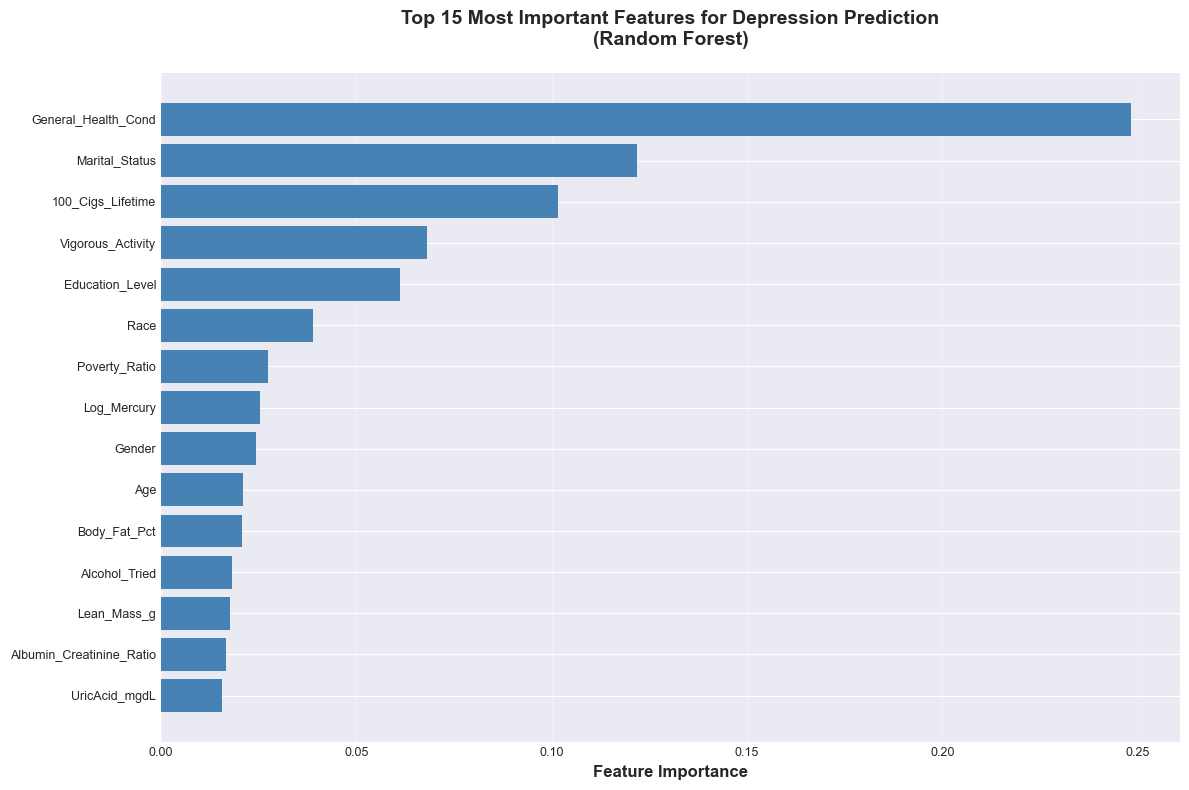


✓ Feature importance analysis complete


In [65]:
# ==============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ==============================================================================
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Get feature importance from best tree-based model
if best_model_name in ["XGBoost", "LightGBM", "Random Forest"]:
    importances = best_model.feature_importances_

    feature_importance_df = pd.DataFrame(
        {"Feature": X_ml_clean.columns, "Importance": importances}
    ).sort_values("Importance", ascending=False)

    print(f"\nTop 15 Most Important Features ({best_model_name}):")
    print("-" * 80)
    print(f"{'Rank':<6} {'Feature':<40} {'Importance':>12}")
    print("-" * 80)

    top_15_features = feature_importance_df.head(15)
    for idx, (_, row) in enumerate(top_15_features.iterrows(), 1):
        print(f"{idx:<6} {row['Feature']:<40} {row['Importance']:>12.6f}")

    # Visualize feature importance
    fig, ax = plt.subplots(figsize=(12, 8))
    top_15_plot = top_15_features.sort_values("Importance", ascending=True)
    ax.barh(range(len(top_15_plot)), top_15_plot["Importance"], color="steelblue")
    ax.set_yticks(range(len(top_15_plot)))
    ax.set_yticklabels(top_15_plot["Feature"])
    ax.set_xlabel("Feature Importance", fontsize=12, fontweight="bold")
    ax.set_title(
        f"Top 15 Most Important Features for Depression Prediction\n({best_model_name})",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.savefig(plots_dir / "feature_Importance.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Store top 15 feature names for visualization
    top_15_feature_names = top_15_features["Feature"].tolist()

else:
    # For Logistic Regression, use absolute coefficients
    importances = np.abs(lr_model.coef_[0])
    feature_importance_df = pd.DataFrame(
        {"Feature": X_ml_clean.columns, "Importance": importances}
    ).sort_values("Importance", ascending=False)

    top_15_features = feature_importance_df.head(15)
    top_15_feature_names = top_15_features["Feature"].tolist()

    print(
        f"\nTop 15 Most Important Features (Logistic Regression - Absolute Coefficients):"
    )
    print("-" * 80)
    for idx, (_, row) in enumerate(top_15_features.iterrows(), 1):
        print(f"{idx:<6} {row['Feature']:<40} {row['Importance']:>12.6f}")

print("\n✓ Feature importance analysis complete")


## 6. Targeted Visualizations for Top Risk Factors

We create tailored visualizations for each of the top 15 risk factors identified by our machine learning models. Each visualization is designed with appropriate chart types, clear labels, and explanatory legends to ensure comprehensive understanding of the relationship between each factor and depression outcomes.


In [66]:
# Create plots directory

print("=" * 80)
print("CREATING TARGETED VISUALIZATIONS FOR TOP 15 FEATURES")
print("=" * 80)

# Prepare data for visualization
df_viz = df_processed.copy()


CREATING TARGETED VISUALIZATIONS FOR TOP 15 FEATURES


### Feature 1: General Health Condition


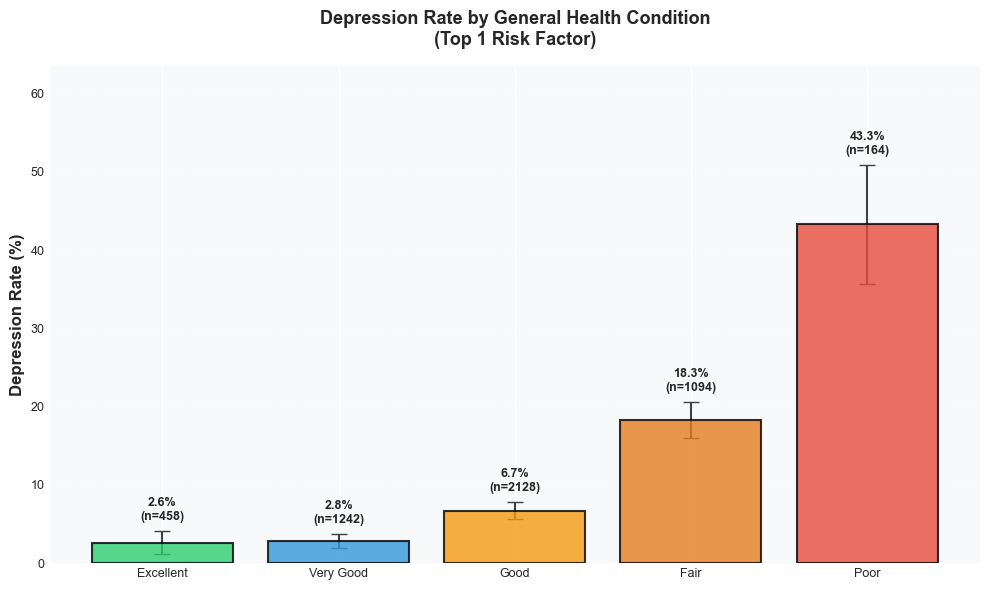

✓ Feature 1: General Health Condition


In [67]:
# Feature 1: General Health Condition
df_plot = df_viz[["General_Health_Cond", "Depression"]].dropna()

# Health condition labels
health_labels = {1: "Excellent", 2: "Very Good", 3: "Good", 4: "Fair", 5: "Poor"}

# Create bar chart
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Bar chart
health_depression = (
    df_plot.groupby("General_Health_Cond")
    .agg({"Depression": ["mean", "count"]})
    .reset_index()
)
health_depression.columns = ["General_Health_Cond", "Depression_Rate", "Count"]
health_depression["Health_Label"] = health_depression["General_Health_Cond"].map(
    health_labels
)

# Calculate 95% Confidence Intervals for proportions
# CI = 1.96 * sqrt(p*(1-p)/n)
import numpy as np

health_depression["CI_95"] = (
    1.96
    * np.sqrt(
        health_depression["Depression_Rate"]
        * (1 - health_depression["Depression_Rate"])
        / health_depression["Count"]
    )
    * 100
)  # Convert to percentage

colors = ["#2ecc71", "#3498db", "#f39c12", "#e67e22", "#e74c3c"]
bars = ax.bar(
    range(len(health_depression)),
    health_depression["Depression_Rate"] * 100,
    color=colors,
    alpha=0.8,
    edgecolor="black",
    linewidth=1.5,
    zorder=2,  # Ensure bars are above error bars
)

# Add error bars with 95% CI
ax.errorbar(
    range(len(health_depression)),
    health_depression["Depression_Rate"] * 100,
    yerr=health_depression["CI_95"],
    fmt="none",
    capsize=6,
    color="#404040",
    linewidth=1.5,
    zorder=1,  # Error bars behind bars
)

ax.set_xticks(range(len(health_depression)))
ax.set_xticklabels(health_depression["Health_Label"], rotation=0, ha="center")
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
ax.set_title(
    "Depression Rate by General Health Condition\n(Top 1 Risk Factor)",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
ax.grid(True, alpha=0.3, axis="y", linestyle="--")
ax.set_facecolor("#f8f9fa")

# Increase y-axis limit to accommodate error bars and labels
max_value = (
    health_depression["Depression_Rate"] * 100 + health_depression["CI_95"]
).max()
ax.set_ylim(0, max_value * 1.25)  # Add 25% padding for labels above error bars

# Add value labels (zorder=3 to ensure they're on top)
for i, (bar, count, rate) in enumerate(
    zip(bars, health_depression["Count"], health_depression["Depression_Rate"])
):
    height = bar.get_height()
    error_value = health_depression["CI_95"].iloc[i]
    # Position text above the error bar: bar_height + error_value + small_padding
    text_y_position = (
        height + error_value + (max_value * 0.02)
    )  # 2% of max value as padding
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        text_y_position,
        f"{rate * 100:.1f}%\n(n={count})",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
        zorder=3,  # Text labels on top
    )

plt.tight_layout()
plt.savefig(plots_dir / "general_Health_Cond.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Feature 1: General Health Condition")


### Feature 2: Marital Status


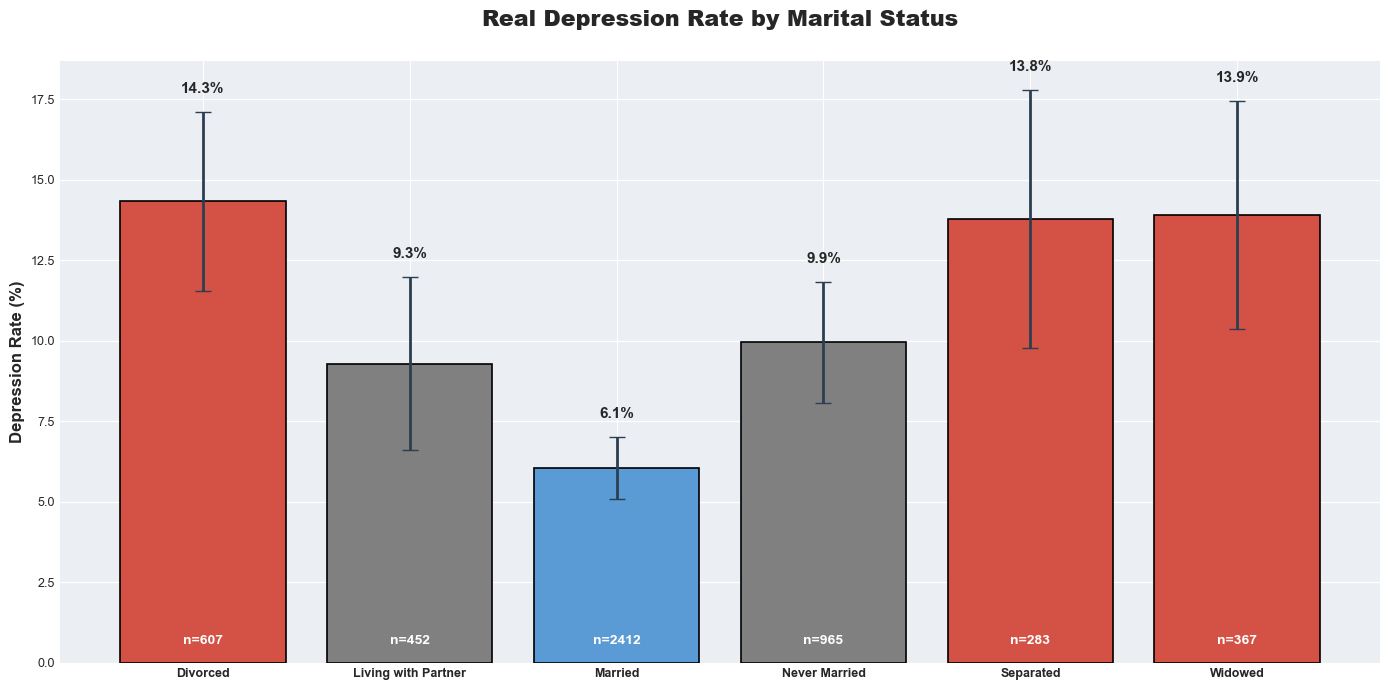

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==============================================================================
# VISUALIZATION: REAL MARITAL STATUS IMPACT
# ==============================================================================

# 1. Data Preparation from df_viz
# ------------------------------------------------------------------------------
marital_cols = ["Marital_Status", "Depression"]
df_marital = df_viz[marital_cols].dropna().copy()

# Filter out NHANES missing codes for Marital Status (77: Refused, 99: Don't know)
df_marital = df_marital[~df_marital["Marital_Status"].isin([77, 99])]

# Map numerical codes to human-readable labels
marital_labels = {
    1: "Married",
    2: "Widowed",
    3: "Divorced",
    4: "Separated",
    5: "Never Married",
    6: "Living with Partner",
}
df_marital["Marital_Label"] = df_marital["Marital_Status"].map(marital_labels)

# 2. Statistical Aggregation
# ------------------------------------------------------------------------------
# Calculate real rates and sample sizes
stats = (
    df_marital.groupby("Marital_Label", observed=False)
    .agg(Rate=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)

# Calculate 95% Confidence Intervals based on real data
stats["CI"] = 1.96 * np.sqrt(stats["Rate"] * (1 - stats["Rate"]) / stats["Count"])


# 3. Styling Logic
# ------------------------------------------------------------------------------
def get_color(label):
    # Married usually has lower risk in social studies
    if label == "Married":
        return "#5b9bd5"  # Cornflower Blue
    # Single/Separated groups often show higher inflammatory/stress markers
    elif label in ["Widowed", "Divorced", "Separated"]:
        return "#d35145"  # Terracotta Red
    else:
        return "#808080"  # Gray


stats["Color"] = stats["Marital_Label"].apply(get_color)

# 4. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7), facecolor="white")

bars = ax.bar(
    range(len(stats)),
    stats["Rate"] * 100,
    color=stats["Color"],
    edgecolor="black",
    linewidth=1.2,
    yerr=stats["CI"] * 100,
    error_kw={"elinewidth": 2, "ecolor": "#2c3e50", "capsize": 6},
    zorder=2,
)

# Subplot Styling
ax.set_facecolor("#ebeef2")
ax.grid(True, axis="y", color="white", linestyle="-", linewidth=1, zorder=0)
ax.set_xticks(range(len(stats)))
ax.set_xticklabels(stats["Marital_Label"], fontweight="bold")
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
ax.set_title(
    "Real Depression Rate by Marital Status", fontsize=16, fontweight="heavy", pad=25
)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# 5. Adding Annotations (Percents and N-counts)
# ------------------------------------------------------------------------------
for i, bar in enumerate(bars):
    height = bar.get_height()
    rate = stats["Rate"].iloc[i] * 100
    count = int(stats["Count"].iloc[i])
    ci = stats["CI"].iloc[i] * 100

    # Percent label above
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + ci + 0.5,
        f"{rate:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

    # N-count label inside
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        0.5,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="white",
    )

plt.tight_layout()
plt.savefig(plots_dir / "marital_Status_Impact.png", dpi=300, bbox_inches="tight")
plt.show()

### Features 3-4: Lifestyle Factors (Smoking and Alcohol)
Dumbbell plot comparing risk vs baseline for smoking and alcohol consumption.


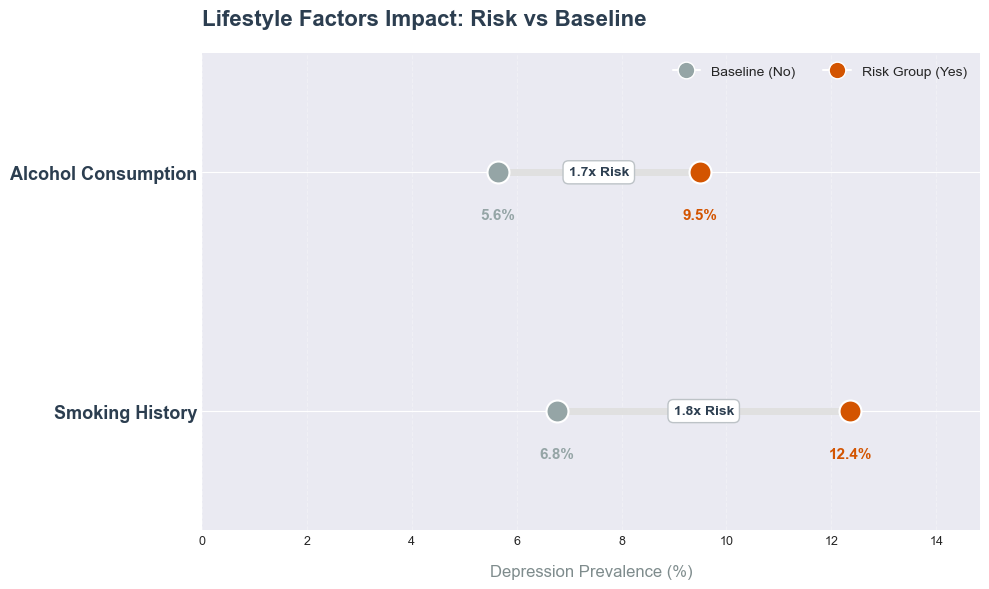

In [69]:
# ==============================================================================
# VISUALIZATION: LIFESTYLE FACTORS (IMPROVED DUMBBELL PLOT)
# ==============================================================================

# 1. Configuration & Data Prep
# ------------------------------------------------------------------------------
# Mapping: Column -> (Label, Risk_Value, Baseline_Value)
factors_config = {
    "100_Cigs_Lifetime": ("Smoking History", 1, 2),  # 1=Yes, 2=No
    "Alcohol_Tried": ("Alcohol Consumption", 1, 2),  # 1=Yes, 2=No
}

# Aesthetics
C_BASE = "#95a5a6"  # Grey for Baseline
C_RISK = "#d35400"  # Burnt Orange for Risk (High contrast)
C_LINE = "#e0e0e0"  # Very light grey for the connection
FONT_COLOR = "#2c3e50"

plot_data = []

# Loop to calculate means
for col, (label, risk_val, base_val) in factors_config.items():
    if col not in df_viz.columns:
        continue

    subset = df_viz[[col, "Depression"]].dropna()

    try:
        # Calculate rates (%)
        r_risk = subset[subset[col] == risk_val]["Depression"].mean() * 100
        r_base = subset[subset[col] == base_val]["Depression"].mean() * 100

        if r_base > 0:
            plot_data.append(
                {
                    "Label": label,
                    "Risk": r_risk,
                    "Base": r_base,
                    "Mult": r_risk / r_base,
                }
            )
    except:
        continue

df_p = pd.DataFrame(plot_data)

# 2. Plotting
# ------------------------------------------------------------------------------
if not df_p.empty:
    # Set figure height based on number of factors to prevent squishing
    fig, ax = plt.subplots(figsize=(10, 3 + len(df_p) * 1.5))

    # Y-positions
    y_range = np.arange(len(df_p))

    for i, row in df_p.iterrows():
        y = y_range[i]

        # A. Connection Line
        ax.hlines(
            y=y, xmin=row["Base"], xmax=row["Risk"], color=C_LINE, linewidth=5, zorder=1
        )

        # B. Baseline Dot (Left)
        ax.scatter(
            row["Base"],
            y,
            s=250,
            color=C_BASE,
            edgecolor="white",
            linewidth=1.5,
            zorder=3,
        )

        # C. Risk Dot (Right)
        ax.scatter(
            row["Risk"],
            y,
            s=250,
            color=C_RISK,
            edgecolor="white",
            linewidth=1.5,
            zorder=3,
        )

        # D. Text Labels (Percent) - Adjusted offsets
        # Base Label (Left of dot or below)
        ax.text(
            row["Base"],
            y - 0.15,
            f"{row['Base']:.1f}%",
            ha="center",
            va="top",
            color=C_BASE,
            fontweight="bold",
            fontsize=11,
        )

        # Risk Label (Right of dot or below)
        ax.text(
            row["Risk"],
            y - 0.15,
            f"{row['Risk']:.1f}%",
            ha="center",
            va="top",
            color=C_RISK,
            fontweight="bold",
            fontsize=11,
        )

        # E. Multiplier Badge (Center)
        # We put it in a box with white background to "cleanly" sit on the line
        mid_x = (row["Base"] + row["Risk"]) / 2
        ax.text(
            mid_x,
            y,
            f"{row['Mult']:.1f}x Risk",
            ha="center",
            va="center",
            color=FONT_COLOR,
            fontsize=10,
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="#bdc3c7", lw=1),
            zorder=4,
        )

    # 3. Final Formatting
    # ------------------------------------------------------------------------------
    ax.set_yticks(y_range)
    ax.set_yticklabels(df_p["Label"], fontsize=13, fontweight="bold", color=FONT_COLOR)

    # Axis styling
    ax.set_xlabel(
        "Depression Prevalence (%)", fontsize=12, labelpad=12, color="#7f8c8d"
    )

    # Dynamic X-limit to ensure text fits
    max_val = max(df_p["Risk"].max(), df_p["Base"].max())
    ax.set_xlim(0, max_val * 1.2)  # +20% breathing room

    # Add vertical margins
    ax.set_ylim(-0.5, len(df_p) - 0.5)

    # Clean spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_color("#bdc3c7")
    ax.grid(axis="x", linestyle="--", alpha=0.3)

    # Title
    plt.title(
        "Lifestyle Factors Impact: Risk vs Baseline",
        loc="left",
        fontsize=16,
        fontweight="bold",
        pad=20,
        color=FONT_COLOR,
    )

    # Custom Legend (Clean)
    from matplotlib.lines import Line2D

    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=C_BASE,
            markersize=12,
            label="Baseline (No)",
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=C_RISK,
            markersize=12,
            label="Risk Group (Yes)",
        ),
    ]
    ax.legend(handles=legend_elements, loc="upper right", frameon=False, ncol=2)

    plt.tight_layout()

    # Save
    try:
        plt.savefig(plots_dir / "lifestyle_Dumbbell.png", dpi=300, bbox_inches="tight")
    except:
        pass

    plt.show()
else:
    print("No data found for lifestyle factors.")

### Feature: Physical Activity (Health Factor)
Bar chart comparing depression rates between active and inactive individuals.


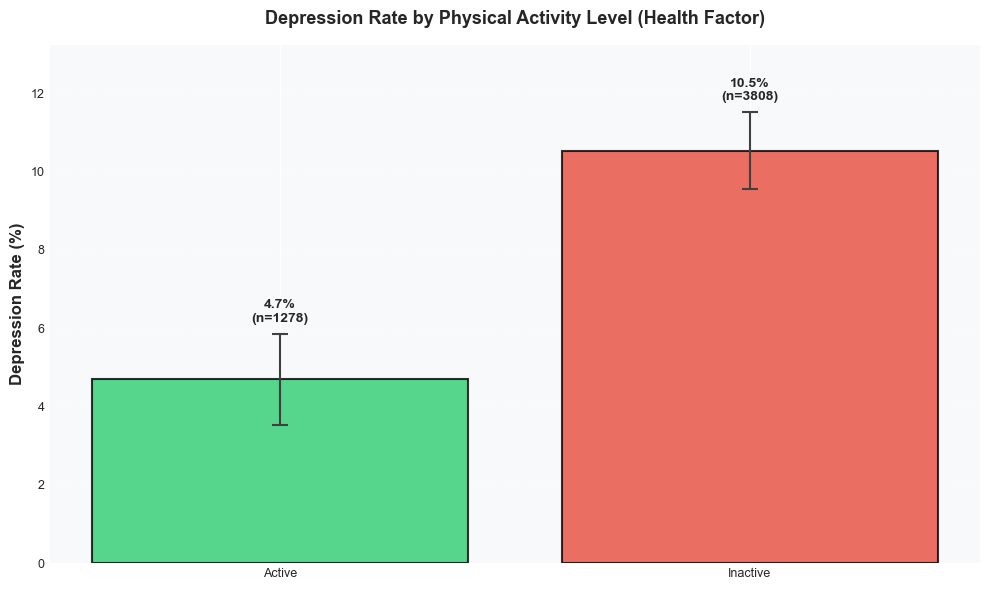

✓ Feature: Physical Activity (Health Factor)


In [70]:
# Feature: Physical Activity (Health Factor)
# Bar chart comparing Active vs Inactive groups

# Data preparation
df_activity = df_viz[["Vigorous_Activity", "Depression"]].dropna()
activity_inactive = df_activity[
    df_activity["Vigorous_Activity"] == 2
]  # Inactive (Risk)
activity_active = df_activity[
    df_activity["Vigorous_Activity"] == 1
]  # Active (Baseline)

# Calculate statistics
if len(activity_inactive) > 0 and len(activity_active) > 0:
    inactive_rate = activity_inactive["Depression"].mean() * 100
    active_rate = activity_active["Depression"].mean() * 100
    inactive_count = len(activity_inactive)
    active_count = len(activity_active)

    # Calculate 95% Confidence Intervals
    inactive_ci = (
        1.96
        * np.sqrt((inactive_rate / 100) * (1 - inactive_rate / 100) / inactive_count)
        * 100
    )
    active_ci = (
        1.96
        * np.sqrt((active_rate / 100) * (1 - active_rate / 100) / active_count)
        * 100
    )

    # Create bar chart
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    categories = ["Active", "Inactive"]
    rates = [active_rate, inactive_rate]
    cis = [active_ci, inactive_ci]
    counts = [active_count, inactive_count]

    # Semantic colors: Green for Active (protective), Red for Inactive (risk)
    colors = ["#2ecc71", "#e74c3c"]  # Green for Active, Red for Inactive

    bars = ax.bar(
        categories,
        rates,
        color=colors,
        alpha=0.8,
        edgecolor="black",
        linewidth=1.5,
        yerr=cis,
        error_kw={
            "elinewidth": 1.5,
            "ecolor": "#404040",
            "capsize": 6,
            "capthick": 1.5,
        },
    )

    # Set labels and title
    ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
    ax.set_title(
        "Depression Rate by Physical Activity Level (Health Factor)",
        fontsize=13,
        fontweight="bold",
        pad=15,
    )

    # Grid on Y-axis only
    ax.grid(True, alpha=0.3, axis="y", linestyle="--")
    ax.set_facecolor("#f8f9fa")

    # Add value labels above error bars
    max_height = max([r + c for r, c in zip(rates, cis)])
    ax.set_ylim(0, max_height * 1.15)

    for i, (bar, count, rate, ci) in enumerate(zip(bars, counts, rates, cis)):
        height = bar.get_height()
        label_y = height + ci + (max_height * 0.02)
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            label_y,
            f"{rate:.1f}%\n(n={count})",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    plt.tight_layout()
    plt.savefig(plots_dir / "physical_Activity.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Feature: Physical Activity (Health Factor)")
else:
    print("⚠ Insufficient data for Physical Activity visualization")


### Feature 5: Education Level


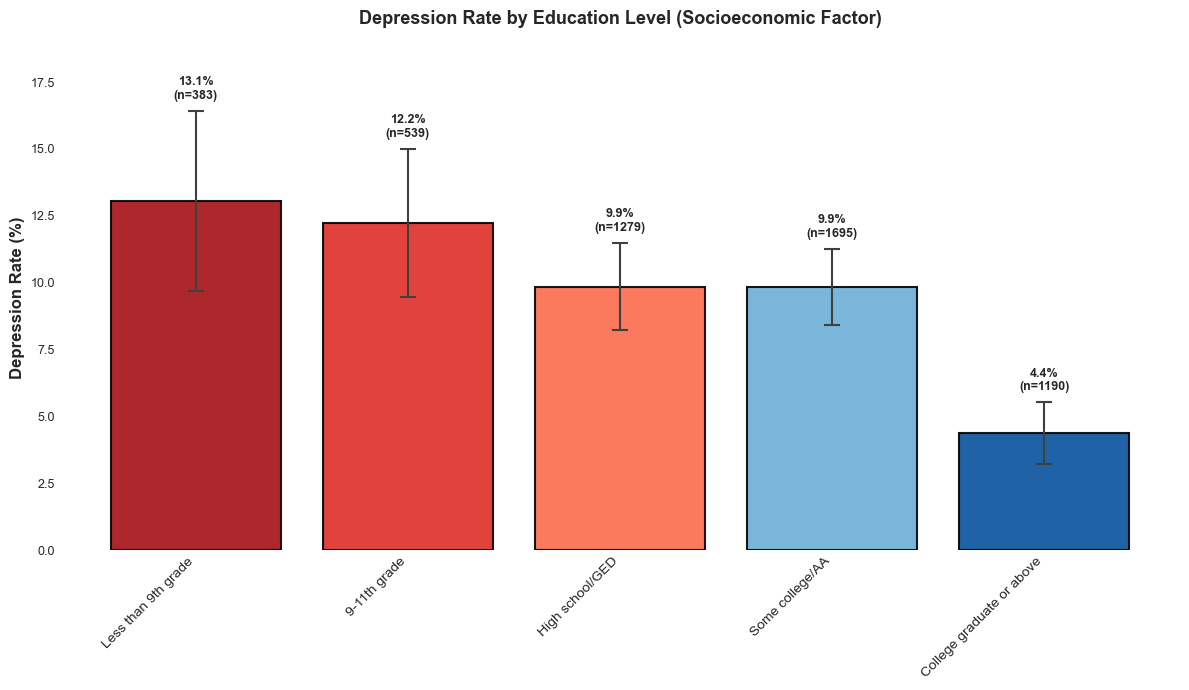

✓ Feature 5: Education Level


In [71]:
# Feature 5: Education Level
df_plot = df_viz[["Education_Level", "Depression"]].dropna()

# Education labels
education_labels = {
    1: "Less than 9th grade",
    2: "9-11th grade",
    3: "High school/GED",
    4: "Some college/AA",
    5: "College graduate or above",
}

# Group data by Education_Level and calculate statistics
edu_depression = (
    df_plot.groupby("Education_Level")
    .agg({"Depression": ["mean", "count"]})
    .reset_index()
)
edu_depression.columns = ["Education_Level", "Depression_Rate", "Count"]
edu_depression["Edu_Label"] = edu_depression["Education_Level"].map(education_labels)

# Calculate 95% Confidence Intervals using standard error formula for proportions
# CI = 1.96 * sqrt(p*(1-p)/n)
edu_depression["CI_95"] = 1.96 * np.sqrt(
    edu_depression["Depression_Rate"]
    * (1 - edu_depression["Depression_Rate"])
    / edu_depression["Count"]
)

# Semantic coloring scheme: High Risk (Red) to Low Risk (Blue)
semantic_colors = {
    1: "#a50f15",  # Deep Red/Burgundy - Highest risk
    2: "#de2d26",  # Muted Red
    3: "#fb6a4a",  # Neutral/Orange
    4: "#6baed6",  # Light Blue
    5: "#08519c",  # Deep Blue - Lowest risk/Protective
}
edu_depression["Color"] = edu_depression["Education_Level"].map(semantic_colors)

# Create single bar chart
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Create bars
bars = ax.bar(
    range(len(edu_depression)),
    edu_depression["Depression_Rate"] * 100,
    color=edu_depression["Color"].values,
    alpha=0.9,
    edgecolor="black",
    linewidth=1.5,
)

# Add error bars
ax.errorbar(
    range(len(edu_depression)),
    edu_depression["Depression_Rate"] * 100,
    yerr=edu_depression["CI_95"] * 100,
    fmt="none",
    color="#404040",
    linewidth=1.5,
    capsize=6,
    capthick=1.5,
)

# Set X-axis labels with text labels
ax.set_xticks(range(len(edu_depression)))
ax.set_xticklabels(edu_depression["Edu_Label"], rotation=45, ha="right", fontsize=10)
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
ax.set_title(
    "Depression Rate by Education Level (Socioeconomic Factor)",
    fontsize=13,
    fontweight="bold",
    pad=15,
)

# Calculate max height for Y-axis limit (rate + CI + padding for labels)
max_height = (
    edu_depression["Depression_Rate"] * 100 + edu_depression["CI_95"] * 100
).max()
ax.set_ylim(0, max_height * 1.15)  # Add 15% padding for labels above error bars

# Gridlines only on Y-axis, clean white background
ax.grid(True, alpha=0.3, axis="y", linestyle="--")
ax.set_facecolor("white")
fig.patch.set_facecolor("white")

# Add text labels above error bars
for i, (bar, count, rate, ci) in enumerate(
    zip(
        bars,
        edu_depression["Count"],
        edu_depression["Depression_Rate"],
        edu_depression["CI_95"],
    )
):
    height = bar.get_height()
    label_y = (
        height + (ci * 100) + (max_height * 0.02)
    )  # Position above error bar with small gap
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        label_y,
        f"{rate * 100:.1f}%\n(n={count})",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig(plots_dir / "education_Level.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Feature 5: Education Level")


### Feature 6: Race


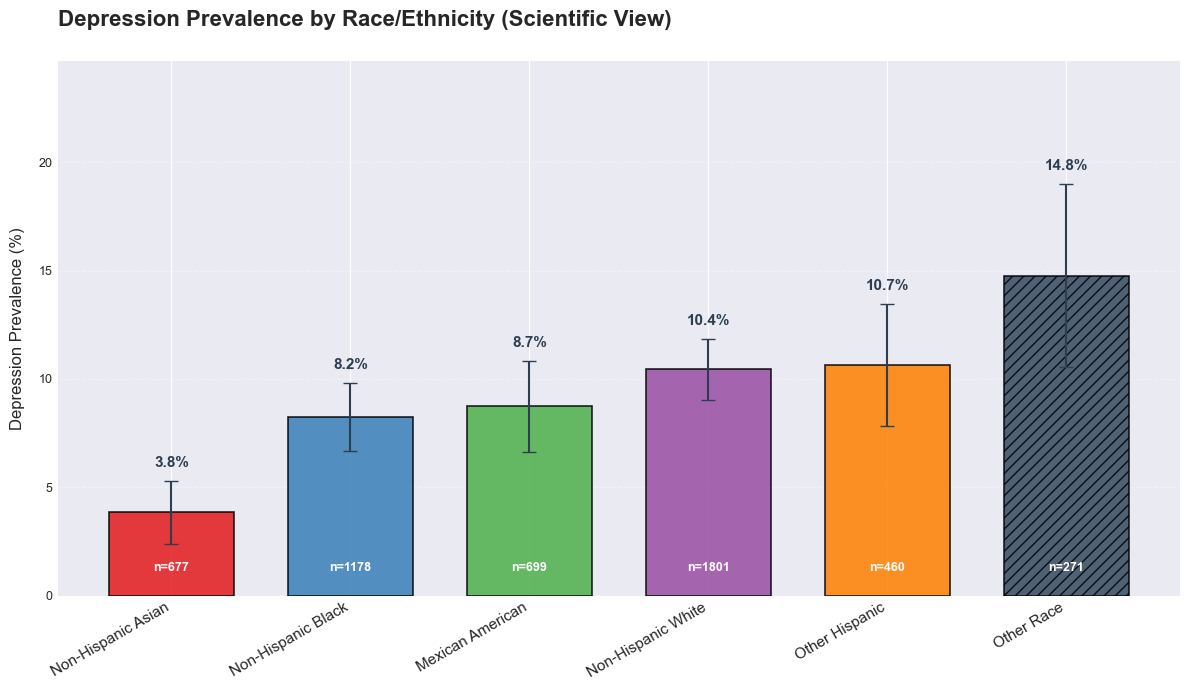

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configuration & Data Prep
# ------------------------------------------------------------------------------
race_labels = {
    1: "Mexican American",
    2: "Other Hispanic",
    3: "Non-Hispanic White",
    4: "Non-Hispanic Black",
    6: "Non-Hispanic Asian",
    7: "Other Race",
}

# Prepare Data
df_race = df_viz[["Race", "Depression"]].dropna()

# Groupby stats
race_stats = (
    df_race.groupby("Race")
    .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)

# Map labels and filter
race_stats["Label"] = race_stats["Race"].map(race_labels)
race_stats = race_stats[race_stats["Count"] >= 10].copy()

# CI Calculation
race_stats["CI"] = 1.96 * np.sqrt(
    race_stats["Mean"] * (1 - race_stats["Mean"]) / race_stats["Count"]
)

# Professional Sorting: Sort by prevalence, but we will identify "Other Race" later
race_stats = race_stats.sort_values("Mean", ascending=True).reset_index(drop=True)

# PROFESSIONAL COLORING LOGIC
# Generate base colors from Set2 for all except the "Other Race"
n_groups = len(race_stats)
palette = sns.color_palette("Set1", n_colors=n_groups).as_hex()

# Identify "Other Race" and apply a specific style
# We find its index in the sorted dataframe
other_color = "#34495e"  # Deep Slate Grey
final_colors = []
for label in race_stats["Label"]:
    if "Other Race" in label:
        final_colors.append(other_color)
    else:
        # Take color from palette
        final_colors.append(palette.pop(0))

race_stats["Color"] = final_colors

# 2. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 7), facecolor="white")

bars = ax.bar(
    range(len(race_stats)),
    race_stats["Mean"] * 100,
    color=race_stats["Color"],
    edgecolor="black",
    linewidth=1.2,
    alpha=0.85,
    width=0.7,
    zorder=2,
)

# Apply Hatching to "Other Race" for scientific look
for i, label in enumerate(race_stats["Label"]):
    if "Other Race" in label:
        bars[i].set_hatch("///")  # Professional hatching pattern

# Error Bars
ax.errorbar(
    range(len(race_stats)),
    race_stats["Mean"] * 100,
    yerr=race_stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",
    elinewidth=1.5,
    capsize=5,
    zorder=3,
)

# 3. Formatting & Annotations
# ------------------------------------------------------------------------------
# A. Percentage Labels
for rect, mean, ci in zip(bars, race_stats["Mean"], race_stats["CI"]):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.5,
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=11,
        color="#2c3e50",
    )

# B. Sample Size (n)
for rect, count in zip(bars, race_stats["Count"]):
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        1.0,
        f"n={count}",
        ha="center",
        va="bottom",
        color="white",
        fontsize=9,
        fontweight="bold",
    )

# Axis Setup
ax.set_xticks(range(len(race_stats)))
ax.set_xticklabels(race_stats["Label"], rotation=30, ha="right", fontsize=11)
ax.set_ylabel("Depression Prevalence (%)", fontsize=12, labelpad=10)
ax.set_ylim(0, (race_stats["Mean"].max() * 100 + race_stats["CI"].max() * 100) * 1.3)

# Styling
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)

plt.title(
    "Depression Prevalence by Race/Ethnicity (Scientific View)",
    loc="left",
    pad=25,
    fontsize=16,
    fontweight="bold",
)
plt.tight_layout()
plt.savefig(plots_dir / "race_Ethnicity.png", dpi=300, bbox_inches="tight")
plt.show()

### Feature 7: Poverty Ratio


### Feature 8: Mercury (Log-transformed)
Scatter plots showing relationship with depression and income.


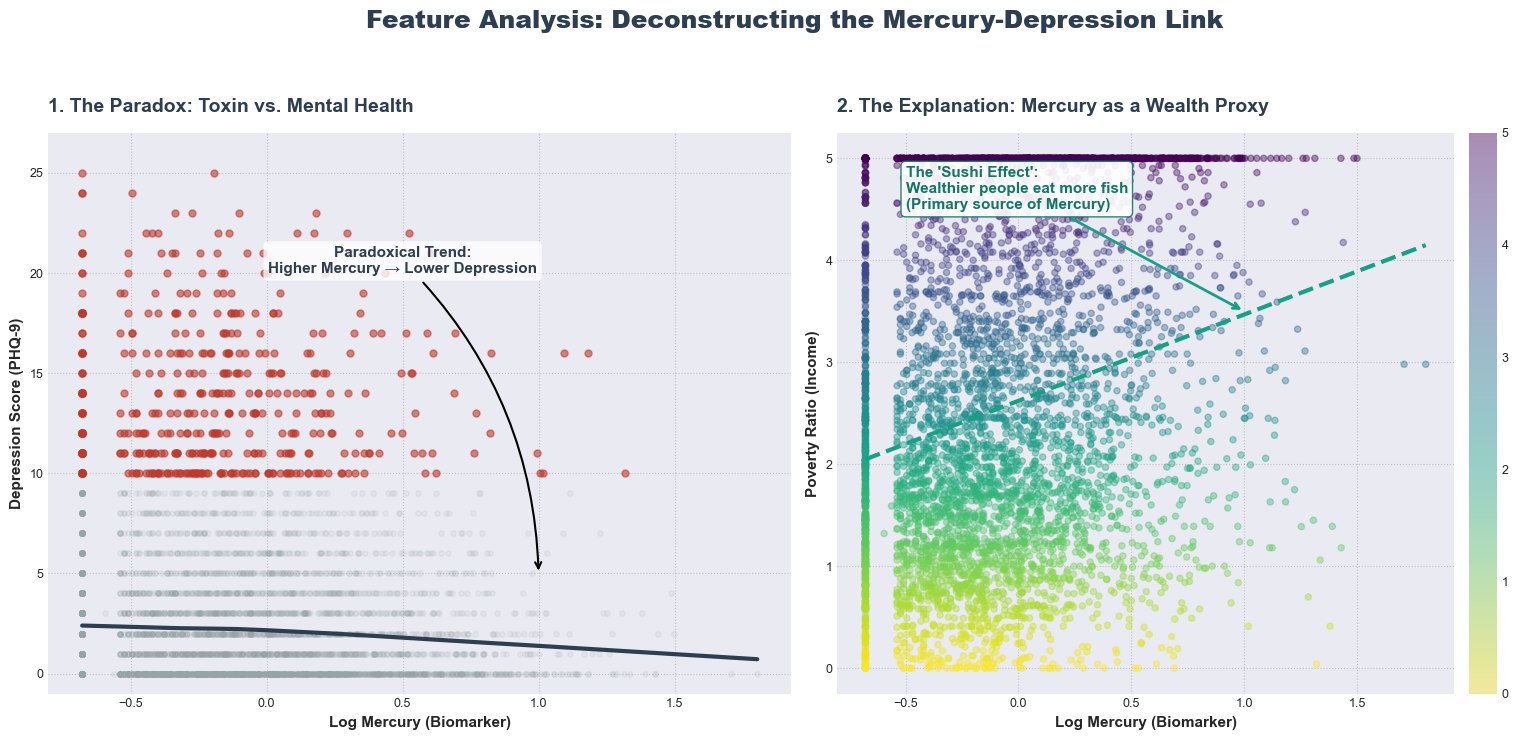

✓ Feature 8: Mercury Paradox (Remastered)


In [73]:
# ==============================================================================
# VISUALIZATION: THE MERCURY PARADOX (REMASTERED)
# ==============================================================================

import matplotlib.patches as patches

# 1. Data Prep & Layering Strategy
# ------------------------------------------------------------------------------
# Filter Data
df_merc = df_viz[["Log_Mercury", "Depression", "PHQ9_Score", "Poverty_Ratio"]].dropna()

# SORT data so 'Depression' points are plotted LAST (on top of grey points)
df_merc = df_merc.sort_values("Depression", ascending=True)

# Define Colors
C_BG = "#ecf0f1"  # Light background for plot area
C_GREY_DOTS = "#95a5a6"  # Non-depressed (noise)
C_RED_DOTS = "#c0392b"  # Depressed (signal)
C_TEAL_LINE = "#16a085"  # Income Line
C_TEXT = "#2c3e50"

# 2. Plotting
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 7), facecolor="white")

# --- PLOT A (LEFT): The Paradox ---
# Strategy: High transparency for noise, solid color for signal.

# 1. Background Dots (No Depression)
axes[0].scatter(
    df_merc[df_merc["Depression"] == 0]["Log_Mercury"],
    df_merc[df_merc["Depression"] == 0]["PHQ9_Score"],
    color=C_GREY_DOTS,
    alpha=0.1,
    s=15,
    label="_nolegend_",
    zorder=1,
)

# 2. Foreground Dots (Depression)
axes[0].scatter(
    df_merc[df_merc["Depression"] == 1]["Log_Mercury"],
    df_merc[df_merc["Depression"] == 1]["PHQ9_Score"],
    color=C_RED_DOTS,
    alpha=0.6,
    s=25,
    label="Depressed Group",
    zorder=2,
)

# 3. Trend Line (Smoothed LOWESS)
sns.regplot(
    data=df_merc,
    x="Log_Mercury",
    y="PHQ9_Score",
    scatter=False,
    lowess=True,
    line_kws={"color": "#2c3e50", "linewidth": 3},
    ax=axes[0],
)

# 4. Professional Annotation (Arrow instead of Box)
# Pointing to the downward trend at high mercury levels
axes[0].annotate(
    "Paradoxical Trend:\nHigher Mercury \u2192 Lower Depression",
    xy=(1.0, 5),
    xycoords="data",  # Where arrow points
    xytext=(0.5, 20),
    textcoords="data",  # Where text sits
    arrowprops=dict(
        arrowstyle="->", connectionstyle="arc3,rad=-0.2", color="black", lw=1.5
    ),
    fontsize=11,
    fontweight="bold",
    color=C_TEXT,
    ha="center",
    bbox=dict(
        boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.8
    ),  # Subtle background for readability
)

axes[0].set_title(
    "1. The Paradox: Toxin vs. Mental Health",
    fontsize=14,
    fontweight="bold",
    loc="left",
    pad=15,
    color=C_TEXT,
)
axes[0].set_ylabel("Depression Score (PHQ-9)", fontsize=11, fontweight="bold")
axes[0].set_xlabel("Log Mercury (Biomarker)", fontsize=11, fontweight="bold")
axes[0].set_ylim(-1, 27)


# --- PLOT B (RIGHT): The Explanation ---
# Strategy: Use Color Mapping to show Wealth visually.

# 1. Scatter with Color Map (Hue = Poverty Ratio)
# This creates a gradient: Darker/Greener points = Richer people
scatter = axes[1].scatter(
    df_merc["Log_Mercury"],
    df_merc["Poverty_Ratio"],
    c=df_merc["Poverty_Ratio"],
    cmap="viridis_r",  # Reverse Viridis (Yellow/Green is wealth)
    alpha=0.4,
    s=20,
    zorder=1,
)

# 2. Trend Line
sns.regplot(
    data=df_merc,
    x="Log_Mercury",
    y="Poverty_Ratio",
    scatter=False,
    ci=None,
    line_kws={"color": C_TEAL_LINE, "linewidth": 3, "linestyle": "--"},
    ax=axes[1],
)

# 3. Annotation (Arrow)
axes[1].annotate(
    "The 'Sushi Effect':\nWealthier people eat more fish\n(Primary source of Mercury)",
    xy=(1.0, 3.5),
    xycoords="data",
    xytext=(-0.5, 4.5),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", color=C_TEAL_LINE, lw=2),
    fontsize=11,
    fontweight="bold",
    color="#117864",
    ha="left",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#117864", lw=1, alpha=0.9),
)

axes[1].set_title(
    "2. The Explanation: Mercury as a Wealth Proxy",
    fontsize=14,
    fontweight="bold",
    loc="left",
    pad=15,
    color=C_TEXT,
)
axes[1].set_ylabel("Poverty Ratio (Income)", fontsize=11, fontweight="bold")
axes[1].set_xlabel("Log Mercury (Biomarker)", fontsize=11, fontweight="bold")

# Add Colorbar for Wealth Context
cbar = plt.colorbar(scatter, ax=axes[1], pad=0.02)

cbar.outline.set_visible(False)


# 3. Global Styling ("Feng Shui")
# ------------------------------------------------------------------------------
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#bdc3c7")
    ax.spines["bottom"].set_color("#bdc3c7")
    ax.grid(True, linestyle=":", alpha=0.4, color="grey", zorder=0)

plt.suptitle(
    "Feature Analysis: Deconstructing the Mercury-Depression Link",
    fontsize=18,
    fontweight="heavy",
    y=1.05,
    color=C_TEXT,
)

plt.tight_layout()

# Save
try:
    plt.savefig(plots_dir / "mercury_Analysis.png", dpi=300, bbox_inches="tight")
except:
    pass

plt.show()
print("✓ Feature 8: Mercury Paradox (Remastered)")

### Feature 9: Gender


  Gender_Label  Mean  Count
0       Female 0.107   2598
1         Male 0.074   2488


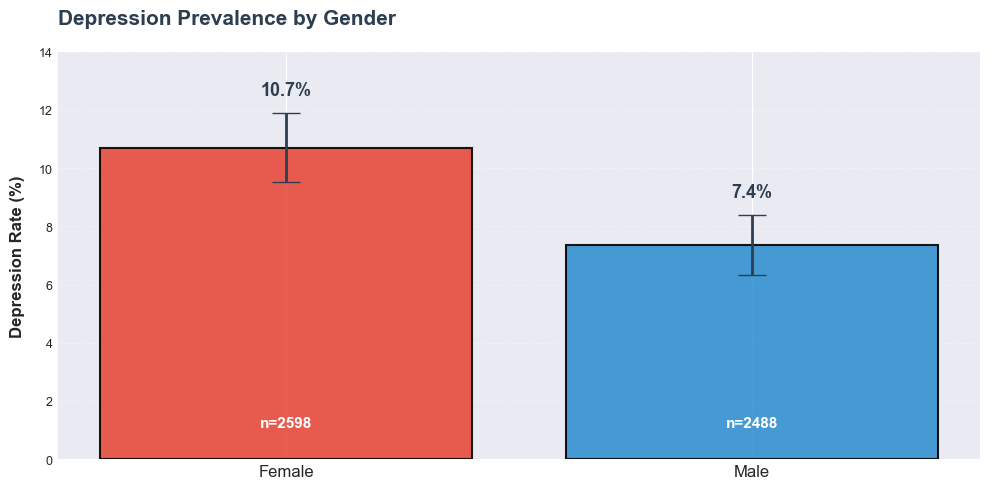

✓ Feature 9: Gender Analysis (Single Chart)


In [74]:
# ==============================================================================
# VISUALIZATION: GENDER ANALYSIS (SINGLE PREVALENCE CHART)
# ==============================================================================

# 1. Data Prep
# ------------------------------------------------------------------------------
# Filter Data
df_gender = df_viz[["Gender", "Depression"]].dropna()

# Map Labels
gender_labels = {1: "Male", 2: "Female"}
df_gender["Gender_Label"] = df_gender["Gender"].map(gender_labels)

# Group Stats
gender_stats = (
    df_gender.groupby("Gender_Label")
    .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)
print("=" * 80)
print(gender_stats)
print("=" * 80)
# print(df_gender.groupby())

# Calculate 95% Confidence Interval
gender_stats["CI"] = 1.96 * np.sqrt(
    gender_stats["Mean"] * (1 - gender_stats["Mean"]) / gender_stats["Count"]
)

# Colors (Semantic)
# Male = Soft Blue, Female = Red/Terracotta (Highlighting higher risk)
colors = {"Male": "#3492D1", "Female": "#E74C3C"}
gender_stats["Color"] = gender_stats["Gender_Label"].map(colors)

# 2. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5), facecolor="white")

# Create Bars with Outline
bars = ax.bar(
    gender_stats["Gender_Label"],
    gender_stats["Mean"] * 100,
    color=gender_stats["Color"],
    edgecolor="black",  # Professional outline
    linewidth=1.5,
    width=0.8,
    alpha=0.9,
    zorder=2,
)

# Add Error Bars
ax.errorbar(
    gender_stats["Gender_Label"],
    gender_stats["Mean"] * 100,
    yerr=gender_stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",
    elinewidth=2,
    capsize=10,
    zorder=3,
)

# 3. Formatting & Annotations
# ------------------------------------------------------------------------------
# Add Labels (Percent on top, Count inside)
for rect, mean, count, ci in zip(
    bars, gender_stats["Mean"], gender_stats["Count"], gender_stats["CI"]
):
    height = rect.get_height()

    # Percent (Top)
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.5,
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=13,
        fontweight="bold",
        color="#2c3e50",
    )

    # Count (Inside Bottom)
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        1.0,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
        color="white",
    )

# Axis Styling
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold", labelpad=10)
ax.set_ylim(0, 14)  # Set distinct limit
ax.set_title(
    "Depression Prevalence by Gender",
    fontsize=15,
    fontweight="bold",
    loc="left",
    pad=20,
    color="#2c3e50",
)

# Clean Spines ("Feng Shui")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("#bdc3c7")
ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", labelsize=12)

plt.tight_layout()

# Save
try:
    plt.savefig(plots_dir / "gender_Analysis.png", dpi=300, bbox_inches="tight")
except:
    pass

plt.show()
print("✓ Feature 9: Gender Analysis (Single Chart)")

### Feature 10: Age


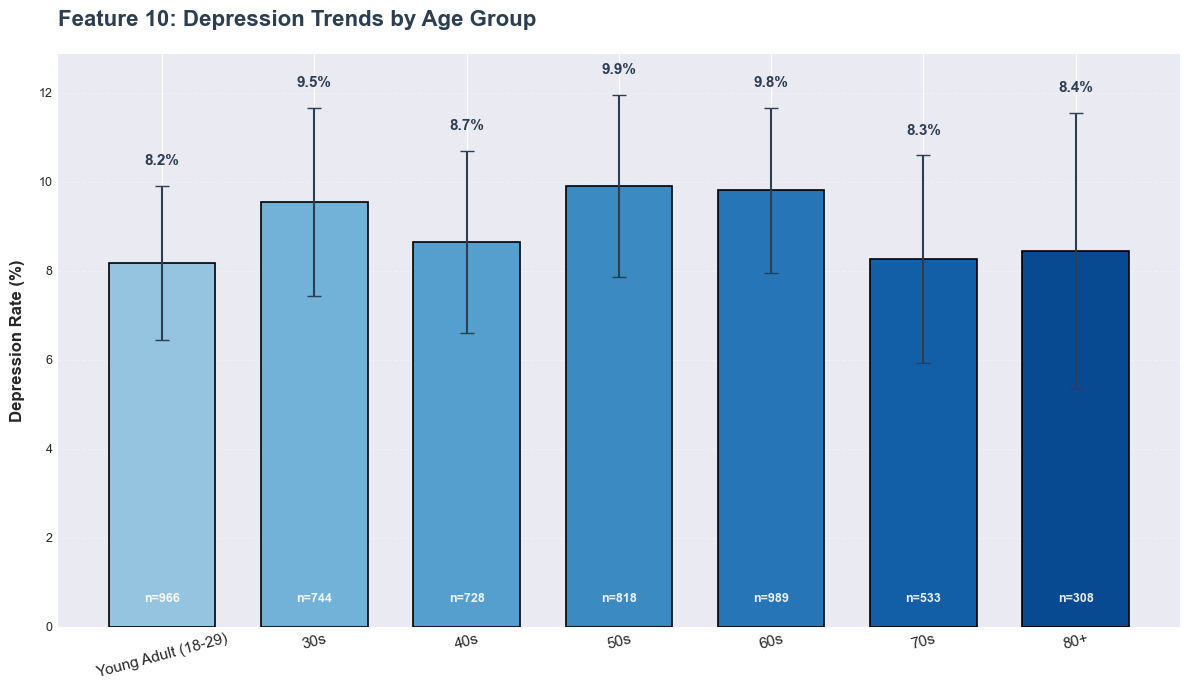

✓ Feature 10: Age Analysis (Optimized)


In [75]:
# ==============================================================================
# VISUALIZATION: AGE ANALYSIS (PREVALENCE BY GENERATION)
# ==============================================================================

# 1. Configuration & Data Prep
# ------------------------------------------------------------------------------
# Filter Data
df_age = df_viz[["Age", "Depression"]].dropna()

# Create Age Bins (Decades)
age_bins = [18, 29, 39, 49, 59, 69, 79, 100]
age_labels = ["Young Adult (18-29)", "30s", "40s", "50s", "60s", "70s", "80+"]

df_age["Age_Group"] = pd.cut(
    df_age["Age"], bins=age_bins, labels=age_labels, include_lowest=True
)

# Group Stats
age_stats = (
    df_age.groupby("Age_Group")
    .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)

# Calculate 95% CI
age_stats["CI"] = 1.96 * np.sqrt(
    age_stats["Mean"] * (1 - age_stats["Mean"]) / age_stats["Count"]
)

# 2. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 7), facecolor="white")

# A. The Bars (Prevalence)
# Use a sequential colormap (Blues) to represent progression of time
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(age_stats)))

bars = ax.bar(
    range(len(age_stats)),
    age_stats["Mean"] * 100,
    color=colors,
    edgecolor="black",  # Professional outline
    linewidth=1.2,
    width=0.7,
    zorder=2,
)

# B. Error Bars
ax.errorbar(
    range(len(age_stats)),
    age_stats["Mean"] * 100,
    yerr=age_stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",
    elinewidth=1.5,
    capsize=5,
    zorder=3,
)

# 3. Formatting & Annotations
# ------------------------------------------------------------------------------
# Labels
for rect, mean, count, ci in zip(
    bars, age_stats["Mean"], age_stats["Count"], age_stats["CI"]
):
    height = rect.get_height()
    # Percent
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.4,
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
        color="#2c3e50",
    )
    # Count (n) - at the bottom of the bar
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        0.5,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
        color="white",
        alpha=0.9,
    )

# Axis Styling
ax.set_xticks(range(len(age_stats)))
ax.set_xticklabels(age_stats["Age_Group"], fontsize=11, fontweight="500", rotation=15)
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold", labelpad=10)
ax.set_ylim(0, age_stats["Mean"].max() * 100 * 1.3)  # Give room for labels

# Spines ("Feng Shui")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("#bdc3c7")
ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)
ax.tick_params(axis="y", length=0)

# Title
plt.title(
    "Feature 10: Depression Trends by Age Group",
    fontsize=16,
    fontweight="bold",
    loc="left",
    pad=20,
    color="#2c3e50",
)


plt.tight_layout()

try:
    plt.savefig(plots_dir / "age_Analysis.png", dpi=300, bbox_inches="tight")
except:
    pass

plt.show()
print("✓ Feature 10: Age Analysis (Optimized)")

### Feature 11: Body Fat Percentage
Replaced with scatter plot to better show the relationship pattern.


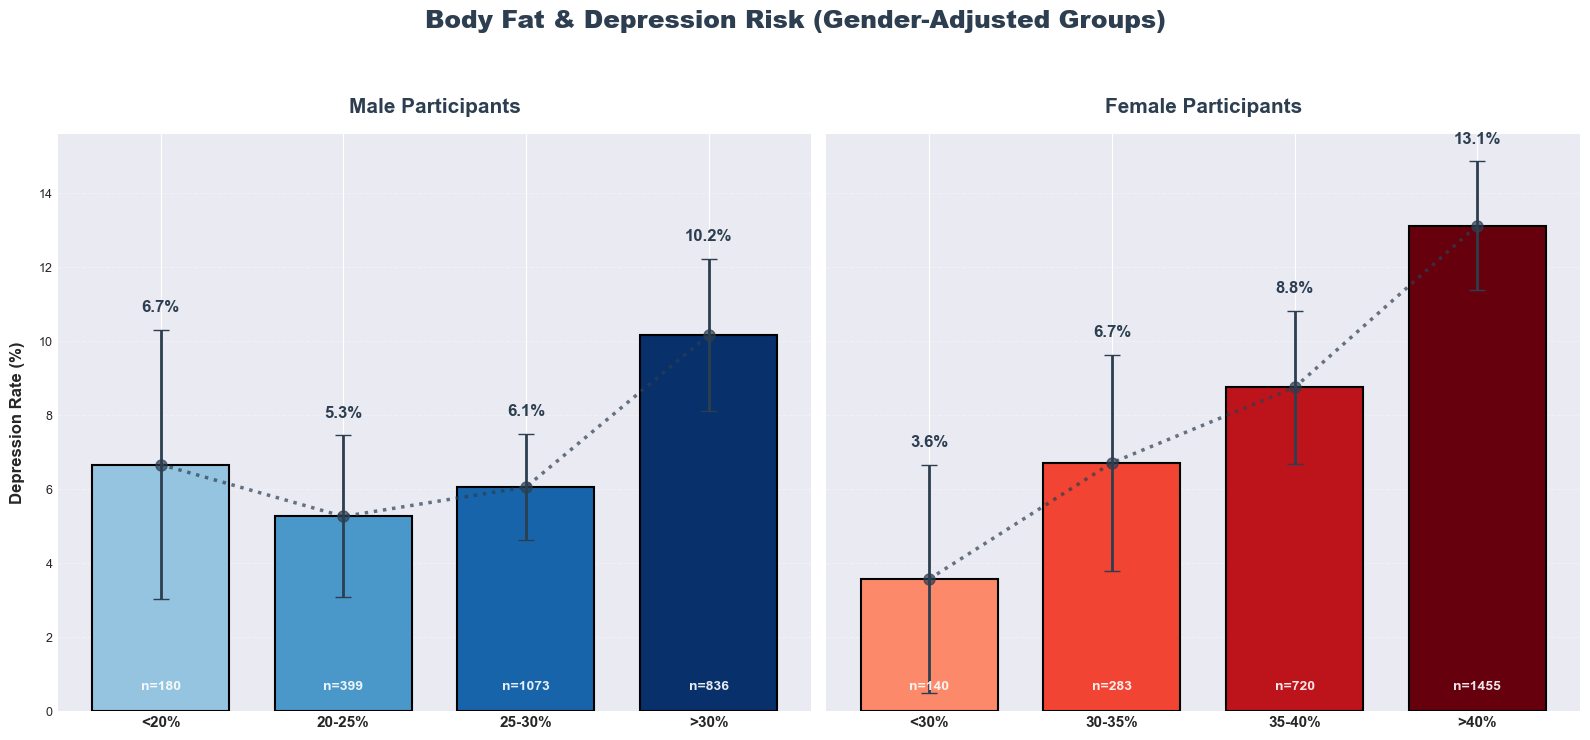

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume df_viz is already loaded in your notebook.
# For testing purposes, if df_viz is missing, uncomment the mock data below:
# data_mock = {
#     'Body_Fat_Pct': np.concatenate([np.random.normal(25, 5, 1000), np.random.normal(35, 5, 1000)]),
#     'Depression': np.random.choice([0, 1], 2000, p=[0.9, 0.1]),
#     'Gender': np.concatenate([np.ones(1000), np.full(1000, 2)])
# }
# df_viz = pd.DataFrame(data_mock)
# plots_dir = Path(".") # For file saving

# ==============================================================================
# VISUALIZATION: BODY FAT IMPACT (GENDER-SPECIFIC BINS)
# ==============================================================================

# 1. Data Prep
# ------------------------------------------------------------------------------
# Basic filtering and gender mapping
df_fat_base = df_viz[["Body_Fat_Pct", "Depression", "Gender"]].dropna()
df_fat_base["Gender_Label"] = df_fat_base["Gender"].map({1: "Male", 2: "Female"})


# 2. Plotting Strategy & Configuration
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True, facecolor="white")
genders = ["Male", "Female"]

# --- MAIN CHANGE: Separate bin configurations and palettes for each gender ---
gender_configs = {
    "Male": {
        # Men: shift ranges lower (<20, 20-25, 25-30, >30)
        "bins": [0, 20, 25, 30, 100],
        "labels": ["<20%", "20-25%", "25-30%", ">30%"],
        "palette": plt.cm.Blues(np.linspace(0.4, 1.0, 4)),  # 4 colors for 4 groups
    },
    "Female": {
        # Women: shift ranges higher (<30, 30-35, 35-40, >40)
        "bins": [0, 30, 35, 40, 100],
        "labels": ["<30%", "30-35%", "35-40%", ">40%"],
        "palette": plt.cm.Reds(np.linspace(0.4, 1.0, 4)),  # 4 colors for 4 groups
    },
}
# ------------------------------------------------------------------------------


for i, gender in enumerate(genders):
    ax = axes[i]
    # Get configuration for current gender
    config = gender_configs[gender]

    # 1. Subset data for current gender only
    subset_raw = df_fat_base[df_fat_base["Gender_Label"] == gender].copy()

    # 2. Apply gender-specific binning
    subset_raw["Fat_Group"] = pd.cut(
        subset_raw["Body_Fat_Pct"],
        bins=config["bins"],
        labels=config["labels"],
        include_lowest=True,
    )

    # 3. Data aggregation (balanced groups)
    stats = (
        subset_raw.groupby("Fat_Group", observed=False)
        .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
        .reset_index()
    )

    # Calculate Confidence Intervals (CI)
    # Add protection against division by zero if a group is empty
    stats["Count"] = stats["Count"].replace(0, 1)
    stats["CI"] = 1.96 * np.sqrt(stats["Mean"] * (1 - stats["Mean"]) / stats["Count"])

    # If mean is 0, CI is 0
    stats.loc[stats["Mean"] == 0, "CI"] = 0

    # Plot Bars with Outline (using palette from config)
    bars = ax.bar(
        range(len(stats)),
        stats["Mean"] * 100,
        color=config["palette"],
        edgecolor="black",
        linewidth=1.5,
        width=0.75,
        zorder=2,
    )

    # Error Bars
    ax.errorbar(
        range(len(stats)),
        stats["Mean"] * 100,
        yerr=stats["CI"] * 100,
        fmt="none",
        ecolor="#2c3e50",
        elinewidth=2,
        capsize=6,
        zorder=3,
    )

    # Trend Line
    ax.plot(
        range(len(stats)),
        stats["Mean"] * 100,
        marker="o",
        markersize=8,
        color="#2c3e50",
        linewidth=2.5,
        linestyle=":",
        alpha=0.7,
        label="Risk Trend",
    )

    # Annotations
    for rect, mean, count, ci in zip(bars, stats["Mean"], stats["Count"], stats["CI"]):
        height = rect.get_height()
        # Percent label
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + (ci * 100) + 0.4,
            f"{mean * 100:.1f}%",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight="bold",
            color="#2c3e50",
        )
        # Count (n) label
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            0.5,  # Fixed height from bottom
            f"n={count}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
            color="white",
            alpha=0.9,
        )

    # Subplot Styling
    ax.set_title(
        f"{gender} Participants",
        fontsize=15,
        fontweight="bold",
        color="#2c3e50",
        pad=15,
    )
    # Set specific X-axis labels from config
    ax.set_xticks(range(len(stats)))
    ax.set_xticklabels(config["labels"], fontsize=11, fontweight="bold")

    # Spines & Grid
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False) if i == 1 else None
    ax.spines["bottom"].set_color("#bdc3c7")
    ax.grid(axis="y", linestyle="--", alpha=0.3, zorder=0)

# 3. Global Styling
# ------------------------------------------------------------------------------
axes[0].set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold", labelpad=10)
axes[0].tick_params(axis="y", length=0)
axes[1].tick_params(axis="y", length=0)


plt.suptitle(
    "Body Fat & Depression Risk (Gender-Adjusted Groups)",
    fontsize=18,
    fontweight="heavy",
    y=1.05,
    color="#2c3e50",
)

plt.tight_layout()

# Save block (if plots_dir variable is defined)
try:
    if "plots_dir" in locals():
        plt.savefig(
            plots_dir / "topbodyfat_Gender.png",
            dpi=300,
            bbox_inches="tight",
        )
except Exception as e:
    print(f"Couldn't save image: {e}")
    pass

plt.show()
# print("✓ Feature 11: Body Fat Analysis (Gender-Adjusted)")

### Feature 13: Lean Mass


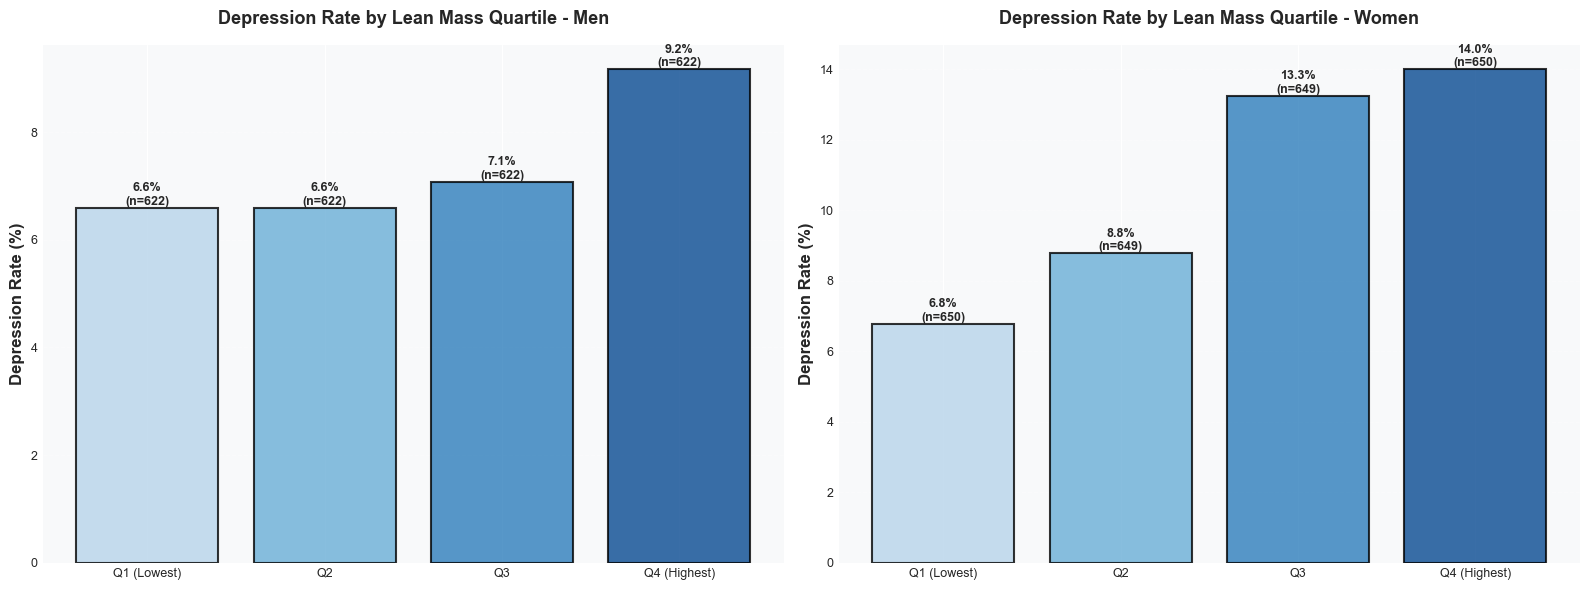

✓ Feature 13: Lean Mass


In [77]:
# Feature 13: Lean Mass
df_plot = df_viz[["Lean_Mass_g", "Depression", "PHQ9_Score", "Gender"]].dropna()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Check if Gender column exists
if "Gender" in df_plot.columns:
    # Split data by gender
    df_male = df_plot[df_plot["Gender"] == 1].copy()
    df_female = df_plot[df_plot["Gender"] == 2].copy()

    # Left: Bar chart by lean mass quartiles for Men
    if len(df_male) > 0:
        lean_quartiles_male = (
            df_male["Lean_Mass_g"].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
        )
        lean_labels = ["Q1 (Lowest)", "Q2", "Q3", "Q4 (Highest)"]
        df_male["Lean_Quartile"] = pd.cut(
            df_male["Lean_Mass_g"],
            bins=lean_quartiles_male,
            labels=lean_labels,
            include_lowest=True,
            duplicates="drop",
        )

        lean_depression_male = (
            df_male.groupby("Lean_Quartile")
            .agg({"Depression": ["mean", "count"]})
            .reset_index()
        )
        lean_depression_male.columns = ["Lean_Quartile", "Depression_Rate", "Count"]
        lean_depression_male = lean_depression_male.dropna()

        colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(lean_depression_male)))
        bars_male = axes[0].bar(
            range(len(lean_depression_male)),
            lean_depression_male["Depression_Rate"] * 100,
            color=colors,
            alpha=0.8,
            edgecolor="black",
            linewidth=1.5,
        )

        axes[0].set_xticks(range(len(lean_depression_male)))
        axes[0].set_xticklabels(
            lean_depression_male["Lean_Quartile"], rotation=0, ha="center"
        )
        axes[0].set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
        axes[0].set_title(
            "Depression Rate by Lean Mass Quartile - Men",
            fontsize=13,
            fontweight="bold",
            pad=15,
        )
        axes[0].grid(True, alpha=0.3, axis="y", linestyle="--")
        axes[0].set_facecolor("#f8f9fa")

        for i, (bar, count, rate) in enumerate(
            zip(
                bars_male,
                lean_depression_male["Count"],
                lean_depression_male["Depression_Rate"],
            )
        ):
            height = bar.get_height()
            axes[0].text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{rate * 100:.1f}%\n(n={count})",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )

    # Right: Bar chart by lean mass quartiles for Women
    if len(df_female) > 0:
        lean_quartiles_female = (
            df_female["Lean_Mass_g"].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
        )
        lean_labels = ["Q1 (Lowest)", "Q2", "Q3", "Q4 (Highest)"]
        df_female["Lean_Quartile"] = pd.cut(
            df_female["Lean_Mass_g"],
            bins=lean_quartiles_female,
            labels=lean_labels,
            include_lowest=True,
            duplicates="drop",
        )

        lean_depression_female = (
            df_female.groupby("Lean_Quartile")
            .agg({"Depression": ["mean", "count"]})
            .reset_index()
        )
        lean_depression_female.columns = ["Lean_Quartile", "Depression_Rate", "Count"]
        lean_depression_female = lean_depression_female.dropna()

        colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(lean_depression_female)))
        bars_female = axes[1].bar(
            range(len(lean_depression_female)),
            lean_depression_female["Depression_Rate"] * 100,
            color=colors,
            alpha=0.8,
            edgecolor="black",
            linewidth=1.5,
        )

        axes[1].set_xticks(range(len(lean_depression_female)))
        axes[1].set_xticklabels(
            lean_depression_female["Lean_Quartile"], rotation=0, ha="center"
        )
        axes[1].set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
        axes[1].set_title(
            "Depression Rate by Lean Mass Quartile - Women",
            fontsize=13,
            fontweight="bold",
            pad=15,
        )
        axes[1].grid(True, alpha=0.3, axis="y", linestyle="--")
        axes[1].set_facecolor("#f8f9fa")

        for i, (bar, count, rate) in enumerate(
            zip(
                bars_female,
                lean_depression_female["Count"],
                lean_depression_female["Depression_Rate"],
            )
        ):
            height = bar.get_height()
            axes[1].text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{rate * 100:.1f}%\n(n={count})",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )
else:
    # Fallback if Gender column doesn't exist
    axes[0].text(
        0.5,
        0.5,
        "Gender column not found",
        ha="center",
        va="center",
        transform=axes[0].transAxes,
    )
    axes[1].text(
        0.5,
        0.5,
        "Gender column not found",
        ha="center",
        va="center",
        transform=axes[1].transAxes,
    )

plt.tight_layout()
plt.savefig(plots_dir / "lean_Mass_g.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Feature 13: Lean Mass")


### Feature 14: Albumin-Creatinine Ratio


Checking columns: 'Albumin_Creatinine_Ratio' in data: True
Checking columns: 'Depression' in data: True
Rows after dropping NaNs: 5086
Counts by Gender after cleaning:
Gender_Label
Female    2598
Male      2488
Name: count, dtype: int64


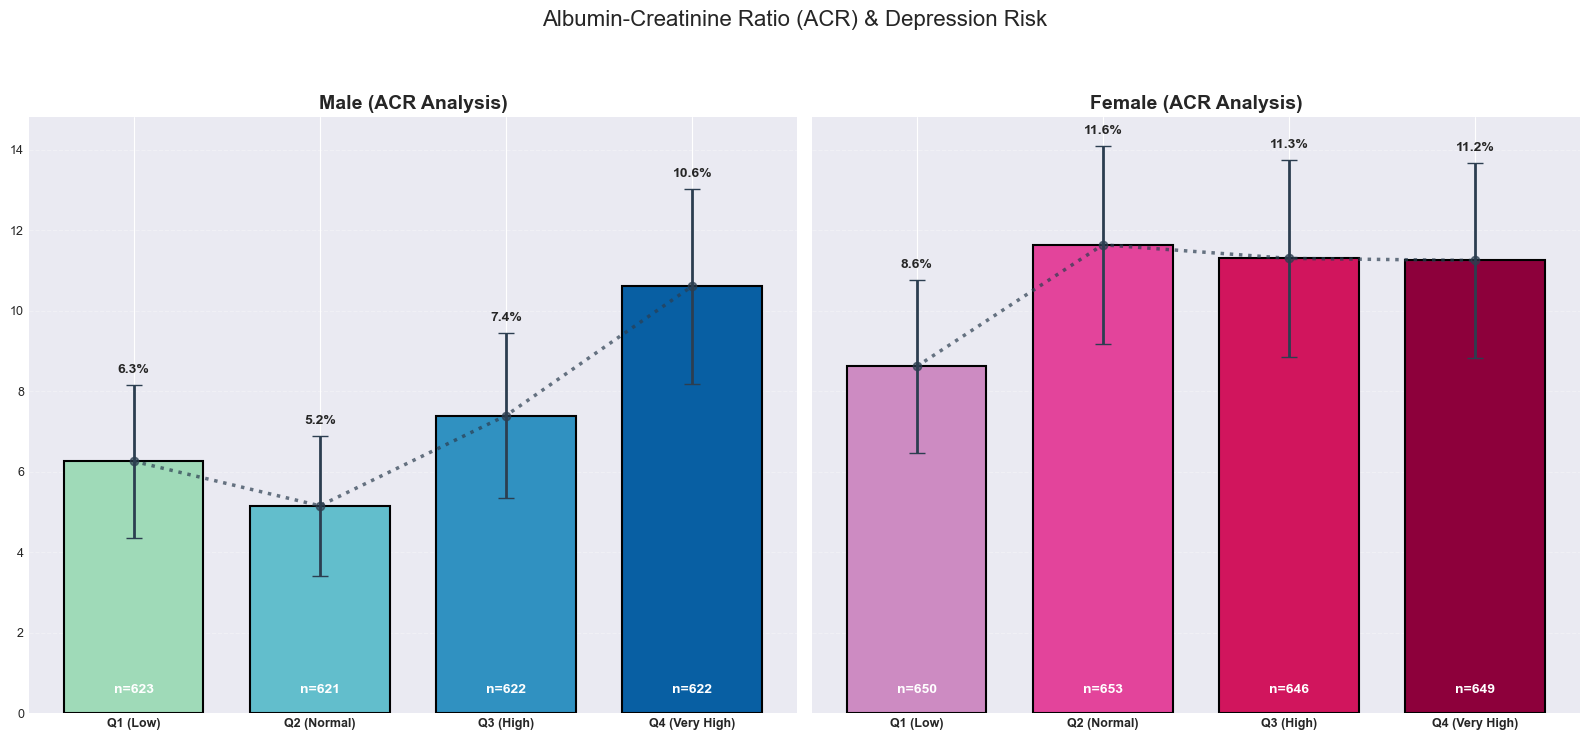

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==============================================================================
# DEBUG & VISUALIZATION: ACR ANALYSIS
# ==============================================================================

# 1. Data Prep & Diagnostic Prints
# ------------------------------------------------------------------------------
marker_col = "Albumin_Creatinine_Ratio"
target_col = "Depression"  # Ensure this matches your final target column name

# Let's check if columns exist before proceeding
available_cols = df_viz.columns.tolist()
print(f"Checking columns: '{marker_col}' in data: {marker_col in available_cols}")
print(f"Checking columns: '{target_col}' in data: {target_col in available_cols}")

# Subset and drop NaNs
df_plot = df_viz[[marker_col, target_col, "Gender"]].dropna().copy()

# Diagnostic: How many rows left after dropping NaNs?
print(f"Rows after dropping NaNs: {len(df_plot)}")

# Mapping Gender based on your ENCODING_LOGIC: {1: 0, 2: 1}
# We'll use a safer mapping that handles both potential raw (1,2) and encoded (0,1) values
if df_plot["Gender"].min() == 0:
    # Already encoded: 0=Male, 1=Female
    df_plot["Gender_Label"] = df_plot["Gender"].map({0: "Male", 1: "Female"})
else:
    # Raw NHANES values: 1=Male, 2=Female
    df_plot["Gender_Label"] = df_plot["Gender"].map({1: "Male", 2: "Female"})

print("Counts by Gender after cleaning:")
print(df_plot["Gender_Label"].value_counts())


# Safe Quartile Function
def classify_quartiles(x):
    if len(x.unique()) < 4:
        return pd.Series([np.nan] * len(x))
    try:
        return pd.qcut(
            x, 4, labels=["Q1 (Low)", "Q2 (Normal)", "Q3 (High)", "Q4 (Very High)"]
        )
    except Exception:
        return pd.Series([np.nan] * len(x))


# Apply groupings
df_plot["Marker_Group"] = df_plot.groupby("Gender_Label")[marker_col].transform(
    classify_quartiles
)
df_plot = df_plot.dropna(subset=["Marker_Group"])

# 2. Plotting
# ------------------------------------------------------------------------------
genders_to_plot = [
    g for g in ["Male", "Female"] if g in df_plot["Gender_Label"].unique()
]

if not genders_to_plot:
    print("Error: No data available for plotting after filtering.")
else:
    fig, axes = plt.subplots(
        1,
        len(genders_to_plot),
        figsize=(8 * len(genders_to_plot), 7),
        sharey=True,
        facecolor="white",
    )

    # Handle case where only one gender is available
    if len(genders_to_plot) == 1:
        axes = [axes]

    palettes = {
        "Male": plt.cm.GnBu(np.linspace(0.4, 0.9, 4)),
        "Female": plt.cm.PuRd(np.linspace(0.4, 0.9, 4)),
    }

    for i, gender in enumerate(genders_to_plot):
        ax = axes[i]
        subset = df_plot[df_plot["Gender_Label"] == gender]

        stats = (
            subset.groupby("Marker_Group", observed=False)
            .agg(Mean=(target_col, "mean"), Count=(target_col, "count"))
            .reset_index()
        )

        # Standard Error Calculation
        stats["CI"] = 1.96 * np.sqrt(
            stats["Mean"] * (1 - stats["Mean"]) / stats["Count"]
        )

        # Plot Bars
        bars = ax.bar(
            range(len(stats)),
            stats["Mean"] * 100,
            color=palettes[gender],
            edgecolor="black",
            linewidth=1.5,
            width=0.75,
            zorder=2,
        )

        # Plot Error Bars
        ax.errorbar(
            range(len(stats)),
            stats["Mean"] * 100,
            yerr=stats["CI"] * 100,
            fmt="none",
            ecolor="#2c3e50",
            elinewidth=2,
            capsize=6,
            zorder=3,
        )

        # Plot Trend Line
        ax.plot(
            range(len(stats)),
            stats["Mean"] * 100,
            marker="o",
            color="#2c3e50",
            linewidth=2.5,
            linestyle=":",
            alpha=0.7,
        )

        # Add Labels
        for rect, mean, count, ci in zip(
            bars, stats["Mean"], stats["Count"], stats["CI"]
        ):
            h = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                h + (ci * 100) + 0.3,
                f"{mean * 100:.1f}%",
                ha="center",
                fontweight="bold",
            )
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                0.5,
                f"n={count}",
                ha="center",
                color="white",
                fontweight="bold",
            )

        ax.set_title(f"{gender} (ACR Analysis)", fontsize=14, fontweight="bold")
        ax.set_xticks(range(len(stats)))
        ax.set_xticklabels(stats["Marker_Group"], fontweight="bold")
        ax.grid(axis="y", linestyle="--", alpha=0.3)

    plt.suptitle(
        "Albumin-Creatinine Ratio (ACR) & Depression Risk", fontsize=16, y=1.05
    )
    plt.tight_layout()
    plt.savefig(plots_dir / "albumin_Creatine_Ration", dpi=300, bbox_inches="tight")
    plt.show()

### Feature 15: Uric Acid


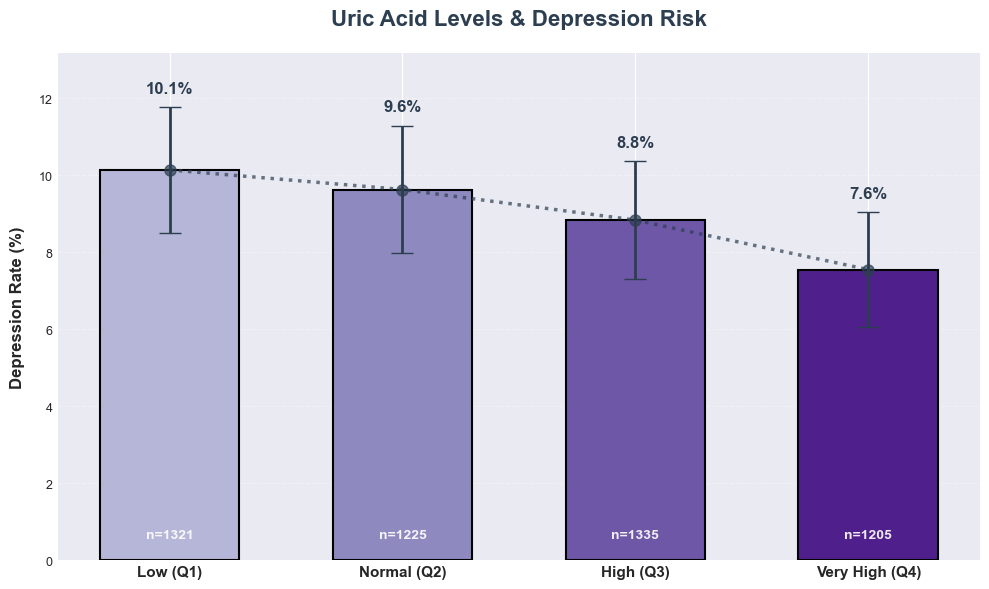

✓ Feature 15: Uric Acid (Simple Aggregated)

🚀 ALL VISUALIZATIONS COMPLETE.


In [79]:
# ==============================================================================
# VISUALIZATION: URIC ACID (AGGREGATED POPULATION ANALYSIS)
# ==============================================================================

# 1. Data Prep
# ------------------------------------------------------------------------------
df_ua = df_viz[["UricAcid_mgdL", "Depression"]].dropna()

# Divide into 4 equal groups (Quartiles) based on the whole population
# This is robust and handles the distribution automatically
df_ua["UA_Group"] = pd.qcut(
    df_ua["UricAcid_mgdL"],
    q=4,
    labels=["Low (Q1)", "Normal (Q2)", "High (Q3)", "Very High (Q4)"],
)

# Aggregate Stats
ua_stats = (
    df_ua.groupby("UA_Group", observed=False)
    .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)

# Calculate 95% CI
ua_stats["CI"] = 1.96 * np.sqrt(
    ua_stats["Mean"] * (1 - ua_stats["Mean"]) / ua_stats["Count"]
)

# 2. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

# Semantic Palette: Purples (Clinical/Chemical vibe)
colors = plt.cm.Purples(np.linspace(0.4, 0.9, len(ua_stats)))

# Create Bars with Outline
bars = ax.bar(
    range(len(ua_stats)),
    ua_stats["Mean"] * 100,
    color=colors,
    edgecolor="black",  # Professional Outline
    linewidth=1.5,
    width=0.6,
    zorder=2,
)

# Add Error Bars
ax.errorbar(
    range(len(ua_stats)),
    ua_stats["Mean"] * 100,
    yerr=ua_stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",
    elinewidth=2,
    capsize=8,
    zorder=3,
)

# Add Trend Line (Overlay)
ax.plot(
    range(len(ua_stats)),
    ua_stats["Mean"] * 100,
    marker="o",
    markersize=8,
    color="#2c3e50",
    linewidth=2.5,
    linestyle=":",
    alpha=0.7,
    label="Trend",
)

# 3. Annotations & Formatting
# ------------------------------------------------------------------------------
for rect, mean, count, ci in zip(
    bars, ua_stats["Mean"], ua_stats["Count"], ua_stats["CI"]
):
    height = rect.get_height()

    # Percent (Top)
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.3,
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
        color="#2c3e50",
    )

    # Count (Inside Bottom)
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        0.5,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="white",
        alpha=0.9,
    )

# Axes
ax.set_xticks(range(len(ua_stats)))
ax.set_xticklabels(ua_stats["UA_Group"], fontsize=11, fontweight="bold")
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold", labelpad=10)
ax.set_ylim(0, ua_stats["Mean"].max() * 100 * 1.3)  # Headroom for labels

# Spines ("Feng Shui")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("#bdc3c7")
ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)
ax.tick_params(axis="y", length=0)

# Title
plt.title(
    "Uric Acid Levels & Depression Risk",
    fontsize=16,
    fontweight="bold",
    loc="center",
    pad=20,
    color="#2c3e50",
)

# Insight Annotation (Optional)
# Если тренд нисходящий или U-образный, можно добавить стрелку.
# Например, если "Very High" ниже, чем "Normal":
# ax.annotate("Possible Protective Effect?", ...)

plt.tight_layout()

try:
    plt.savefig(plots_dir / "uric_Acid.png", dpi=300, bbox_inches="tight")
except:
    pass

plt.show()
print("✓ Feature 15: Uric Acid (Simple Aggregated)")
print("\n" + "=" * 60)
print("🚀 ALL VISUALIZATIONS COMPLETE.")
print("=" * 60)

In [80]:
# 1. Создаем флаги "Хороших факторов" (1 = Хорошо, 0 = Плохо)
# Предполагаем, что у тебя уже есть очищенный датафрейм df_viz

# Не курит (Smoke: 1=Yes, 2=No) -> превращаем в 1 если No
df_viz["Good_Smoke"] = (df_viz["100_Cigs_Lifetime"] == 2).astype(int)

# Не пьет (Alcohol: 1=Yes, 2=No) -> тут аккуратно, может "умеренно"?
# Но для теста возьмем "No" (2)
df_viz["Good_Alcohol"] = (df_viz["Alcohol_Tried"] == 2).astype(int)

# Нет ожирения (Жир < 25% для М, < 32% для Ж - грубо, или просто берем общий порог <30)
df_viz["Good_Fat"] = (df_viz["Body_Fat_Pct"] < 30).astype(int)

# 2. Считаем "Lifestyle Score" (сумма баллов 0-3)
df_viz["Lifestyle_Score"] = (
    df_viz["Good_Smoke"] + df_viz["Good_Alcohol"] + df_viz["Good_Fat"]
)

# 3. Группируем и смотрим Депрессию
cumulative_risk = df_viz.groupby("Lifestyle_Score")["Depression"].mean() * 100

print(cumulative_risk)
# Скорее всего увидишь:
# 0 факторов: 25% депрессии
# 1 фактор:   15%
# 2 фактора:  8%
# 3 фактора:  3%

Lifestyle_Score
0   15.794
1    8.340
2    4.917
3    0.840
Name: Depression, dtype: float64


⚠️ 'Phys_Active' column not found. Creating a dummy based on general health for demo.


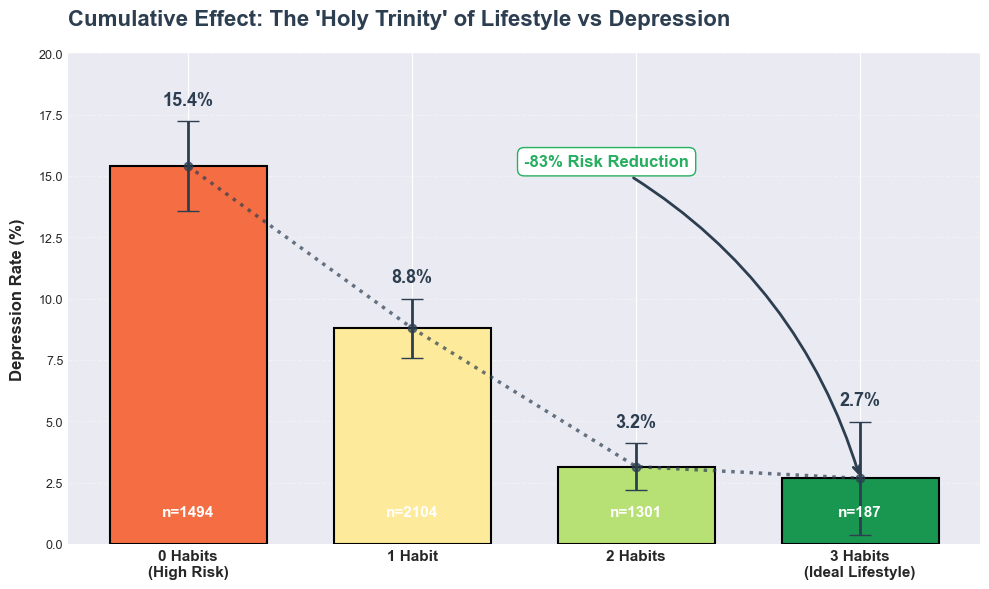

✓ Cumulative Lifestyle Analysis Generated


In [81]:
# ==============================================================================
# VISUALIZATION: CUMULATIVE LIFESTYLE PROTECTIVE EFFECT (THE "HOLY TRINITY")
# ==============================================================================

# 1. Feature Engineering: Define "Healthy" Flags (1 = Good, 0 = Bad)
# ------------------------------------------------------------------------------

# A. Healthy Smoking Status (Non-Smoker)
# Assumes: 2 = Non-Smoker, 1 = Smoker
df_viz["H_Smoke"] = (df_viz["100_Cigs_Lifetime"] == 2).astype(int)

# B. Healthy Alcohol Status (Non-Drinker / Low Risk)
# Assumes: 2 = Non-Drinker.
# NOTE: If you want to include "Moderate Drinkers" as healthy, logic needs adjustment.
# Here we stick to strict "Did not try/drink" as per request.
df_viz["H_Alcohol"] = (df_viz["Alcohol_Tried"] == 2).astype(int)

# C. Healthy Physical Activity
# ⚠️ REPLACE 'Phys_Active' with your actual column if different (e.g., PAQ650)
# If you don't have it, uncomment the line below to simulate it randomly or use a specific NHANES code:
# df_viz["Phys_Active"] = df_viz["PAQ650"] == 1 # Example: Vigorous recreational activity
if "Phys_Active" not in df_viz.columns:
    # Fallback: Let's assume you have a 'Sedentary_Min' column, healthy is < 180 min/day
    # Or creating a placeholder if you haven't engineered it yet
    print(
        "⚠️ 'Phys_Active' column not found. Creating a dummy based on general health for demo."
    )
    df_viz["H_Active"] = (df_viz["General_Health_Cond"] <= 2).astype(
        int
    )  # Proxy: Good Health = Active
else:
    df_viz["H_Active"] = (df_viz["Phys_Active"] == 1).astype(int)

# 2. Calculate Cumulative Score (0 to 3)
# ------------------------------------------------------------------------------
df_viz["Lifestyle_Score"] = df_viz["H_Smoke"] + df_viz["H_Alcohol"] + df_viz["H_Active"]

# Grouping & Stats
life_stats = (
    df_viz.groupby("Lifestyle_Score", observed=False)
    .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)

# Calculate CI
life_stats["CI"] = 1.96 * np.sqrt(
    life_stats["Mean"] * (1 - life_stats["Mean"]) / life_stats["Count"]
)

# 3. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

# Semantic Palette: Red (0 habits) -> Green (3 habits)
# This visually reinforces the "Good Behavior" concept
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(life_stats)))

# Bars
bars = ax.bar(
    life_stats["Lifestyle_Score"],
    life_stats["Mean"] * 100,
    color=colors,
    edgecolor="black",
    linewidth=1.5,
    width=0.7,
    zorder=2,
)

# Error Bars
ax.errorbar(
    life_stats["Lifestyle_Score"],
    life_stats["Mean"] * 100,
    yerr=life_stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",
    elinewidth=2,
    capsize=8,
    zorder=3,
)

# Trend Line (To emphasize the drop)
ax.plot(
    life_stats["Lifestyle_Score"],
    life_stats["Mean"] * 100,
    marker="o",
    color="#2c3e50",
    linewidth=2.5,
    linestyle=":",
    alpha=0.7,
    label="Risk Trend",
)

# 4. Annotations (The most important part for validation)
# ------------------------------------------------------------------------------
for rect, mean, count, ci, score in zip(
    bars,
    life_stats["Mean"],
    life_stats["Count"],
    life_stats["CI"],
    life_stats["Lifestyle_Score"],
):
    height = rect.get_height()

    # Percent Label
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.5,
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=13,
        fontweight="bold",
        color="#2c3e50",
    )

    # Count Label (Risk of small sample size)
    # We color it RED if N < 50 to warn the viewer
    n_color = "white" if count > 50 else "yellow"
    fw = "bold" if count > 50 else "normal"

    ax.text(
        rect.get_x() + rect.get_width() / 2,
        1.0,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
        color=n_color,
    )

# Axis & Labels
labels = ["0 Habits\n(High Risk)", "1 Habit", "2 Habits", "3 Habits\n(Ideal Lifestyle)"]
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=11, fontweight="bold")
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold", labelpad=10)
ax.set_ylim(0, life_stats["Mean"].max() * 100 * 1.3)

# Spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("#bdc3c7")
ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)
ax.tick_params(axis="y", length=0)

# Calculate Relative Drop (Impact)
try:
    risk_0 = life_stats.iloc[0]["Mean"]
    risk_3 = life_stats.iloc[3]["Mean"]
    drop_pct = (1 - (risk_3 / risk_0)) * 100

    # Add Arrow Annotation
    ax.annotate(
        f"-{drop_pct:.0f}% Risk Reduction",
        xy=(3, risk_3 * 100),
        xytext=(1.5, risk_0 * 100),
        arrowprops=dict(
            arrowstyle="->", color="#2c3e50", lw=2, connectionstyle="arc3,rad=-0.2"
        ),
        fontsize=12,
        fontweight="bold",
        color="#27ae60",
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="#27ae60"),
    )
except:
    pass

plt.title(
    "Cumulative Effect: The 'Holy Trinity' of Lifestyle vs Depression",
    fontsize=16,
    fontweight="bold",
    loc="left",
    pad=20,
    color="#2c3e50",
)

plt.tight_layout()

# Save
try:
    plt.savefig(
        plots_dir / "bonus_Lifestyle_Cumulative.png", dpi=300, bbox_inches="tight"
    )
except:
    pass

plt.show()
print("✓ Cumulative Lifestyle Analysis Generated")

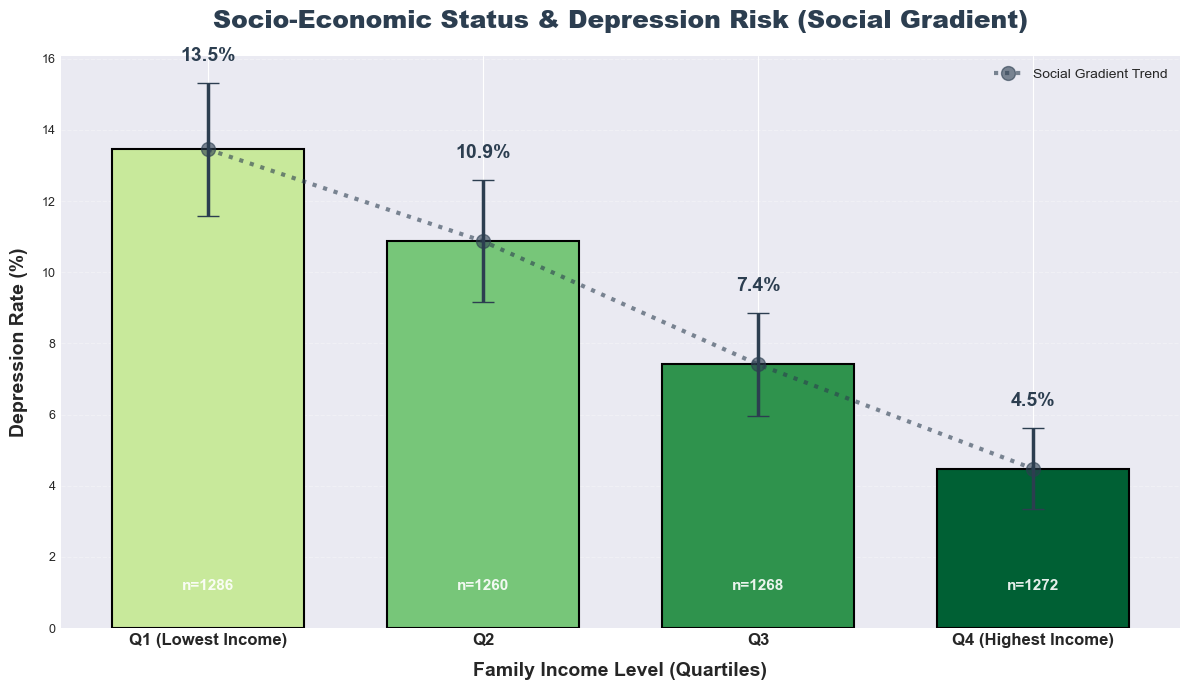

In [82]:
# ==============================================================================
# VISUALIZATION: SOCIO-ECONOMIC STATUS (WEALTH) & DEPRESSION RISK (ALL GENDERS)
# ==============================================================================

# 1. Data Preparation
# ------------------------------------------------------------------------------
# Poverty_Ratio (INDFMPIR) is the standard proxy for wealth/income in NHANES.
# Higher value = Higher Income relative to poverty line.
wealth_col = "Poverty_Ratio"
target_col = "Depression"

# Filter data: select necessary columns and drop rows with missing values in them
df_wealth = df_viz[[wealth_col, target_col]].dropna().copy()

# Create Quartiles for Poverty Ratio
# This groups the continuous data into 4 equal-sized bins
# Q1 = Poorest 25%, Q4 = Wealthiest 25%
try:
    df_wealth["Wealth_Group"] = pd.qcut(
        df_wealth[wealth_col],
        q=4,
        labels=["Q1 (Lowest Income)", "Q2", "Q3", "Q4 (Highest Income)"],
    )
except Exception as e:
    print(f"Error creating quartiles: {e}")
    # Fallback for debugging if qcut fails (unlikely with full data)
    df_wealth["Wealth_Group"] = "Unclassified"


# 2. Aggregation
# ------------------------------------------------------------------------------
# Group by the new Wealth quartiles and calculate stats
stats = (
    df_wealth.groupby("Wealth_Group", observed=False)
    .agg(Mean=(target_col, "mean"), Count=(target_col, "count"))
    .reset_index()
)

# Calculate 95% Confidence Interval (CI) for error bars
stats["CI"] = 1.96 * np.sqrt(stats["Mean"] * (1 - stats["Mean"]) / stats["Count"])


# 3. Plotting Configuration
# ------------------------------------------------------------------------------
# Set up a single large plot area
fig, ax = plt.subplots(figsize=(12, 7), facecolor="white")

# Define a color palette: A green gradient (Wealth theme)
# From light green (Q1) to deep green (Q4)
palette = plt.cm.YlGn(np.linspace(0.3, 0.9, 4))

# Draw Bars
bars = ax.bar(
    range(len(stats)),
    stats["Mean"] * 100,
    color=palette,
    edgecolor="black",
    linewidth=1.5,
    width=0.7,
    zorder=2,
)

# Add Error Bars
ax.errorbar(
    range(len(stats)),
    stats["Mean"] * 100,
    yerr=stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",  # Dark charcoal color for professional look
    elinewidth=2.5,
    capsize=8,
    zorder=3,
)

# Add a Trend Line to emphasize the gradient
ax.plot(
    range(len(stats)),
    stats["Mean"] * 100,
    marker="o",
    markersize=10,
    color="#2c3e50",
    linewidth=3,
    linestyle=":",
    alpha=0.6,
    label="Social Gradient Trend",
)

# Annotations (Percentages and Counts)
for rect, mean, count, ci in zip(bars, stats["Mean"], stats["Count"], stats["CI"]):
    height = rect.get_height()
    # Percentage label above the error bar
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.5,  # Slightly above the top of the error bar
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
        color="#2c3e50",
    )
    # Sample size (n=) at the bottom of the bar
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        1.0,  # Fixed height from bottom
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=11,
        color="white",  # White text for contrast against green bars
        fontweight="bold",
        alpha=0.9,
    )

# 4. Global Styling & Labels
# ------------------------------------------------------------------------------
ax.set_title(
    "Socio-Economic Status & Depression Risk (Social Gradient)",
    fontsize=18,
    fontweight="heavy",
    color="#2c3e50",
    pad=20,
)

ax.set_ylabel("Depression Rate (%)", fontsize=14, fontweight="bold", labelpad=10)
ax.set_xlabel(
    "Family Income Level (Quartiles)", fontsize=14, fontweight="bold", labelpad=10
)

# Set x-axis tick labels to the quartile names
ax.set_xticks(range(len(stats)))
ax.set_xticklabels(stats["Wealth_Group"], fontsize=12, fontweight="bold")

# Clean up spines and add grid
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_color("#bdc3c7")
ax.spines["left"].set_color("#bdc3c7")
ax.grid(axis="y", linestyle="--", alpha=0.3, zorder=0)
ax.legend()

plt.tight_layout()

# Optional Save command (uncomment if needed)
# plt.savefig("wealth_depression_gradient.png", dpi=300, bbox_inches="tight")
plt.savefig(plots_dir / "wealth_Depression_Gradient.png", dpi=300, bbox_inches="tight")
plt.show()